# Load in model

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification


# Download the model
device = "cuda:0"
model_name="EleutherAI/Pythia-70M-deduped"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/root/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load in Sparse AE's

In [2]:
from autoencoders import *
# ae_model_id = ["jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.1", "jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.2.mlp"]
model_id = "jbrinkma/Pythia-70M-deduped-SAEs"
autoencoders = []
layers = model.config.num_hidden_layers
cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.attention") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(1,2)]
cache_names = [item for sublist in cache_names for item in sublist]
filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-attention-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(1,2)]
filenames = [item for sublist in filenames for item in sublist]
for filen in filenames:
    ae_download_location = hf_hub_download(repo_id=model_id, filename=filen)
    autoencoder = torch.load(ae_download_location)
    autoencoder.to_device(device)
    # Freeze autoencoder weights
    autoencoder.encoder.requires_grad_(False)
    autoencoder.encoder_bias.requires_grad_(False)
    autoencoders.append(autoencoder)

# Load training data

In [3]:
# max_seq_length=80 # max length of per data point
# from datasets import load_dataset
# # dataset_name = "NeelNanda/pile-10k"
# dataset_name = "stas/openwebtext-10k"
# dataset = load_dataset(dataset_name, split="train").map(
#     lambda x: tokenizer(x['text']),
#     batched=True
# ).filter(
#     lambda x: len(x['input_ids']) > max_seq_length
# ).map(
#     lambda x: {'input_ids': x['input_ids'][:max_seq_length]}
# )

In [4]:
from activation_dataset import setup_token_data
from utils import dotdict

# Download the dataset
cfg = dotdict()

cfg.dataset_name="stas/openwebtext-10k"
cfg.max_length = 256
cfg.model_batch_size = 4
dataset = setup_token_data(cfg, tokenizer, model)
num_tokens = cfg.max_length*cfg.model_batch_size*len(dataset)
print(f"Number of tokens: {num_tokens}")
num_features, d_model = autoencoder.encoder.shape

Found cached dataset openwebtext-10k (/root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)
Loading cached processed dataset at /root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b/cache-89f7d956ed9de0f6_*_of_00008.arrow


Number of tokens: 11226112


## Model Definitions

In [5]:
from torch.optim import Adam
from torch import nn
class sparse_two_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x
    
class mlp(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
class mlp_no_bias(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.linear2 = nn.Linear(input_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
class sparse_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

    
class sparse_nonlinear_no_bias(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

class linear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
    def forward(self, x):
        x = self.linear(x)
        return x

class linear_no_bias(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=False)
    def forward(self, x):
        x = self.linear(x)
        return x


In [6]:

initialize_weights = False
num_features, d_model = autoencoder.encoder.shape
two_nonlinear_weights = []
mlp_weights = []
nonlinear_weights = []
linear_weights = []
mlp_weights_no_bias = []
nonlinear_weights_no_bias = []
linear_weights_no_bias = []

two_nonlinear_optimizers = []
mlp_optimizers = []
nonlinear_optimizers = []
linear_optimizers = []
mlp_optimizers_no_bias = []
nonlinear_optimizers_no_bias = []
linear_optimizers_no_bias = []
for auto_ind in range(len(autoencoders)//2):
    two_nonlinear_weights.append(sparse_two_nonlinear(num_features))
    two_nonlinear_weights[-1].to(device)
    two_nonlinear_optimizers.append(Adam(two_nonlinear_weights[-1].parameters(), lr=1e-3))

    mlp_weights.append(mlp(num_features))
    mlp_weights[-1].to(device)
    mlp_optimizers.append(Adam(mlp_weights[-1].parameters(), lr=1e-3))

    mlp_weights_no_bias.append(mlp_no_bias(num_features))
    mlp_weights_no_bias[-1].to(device)
    mlp_optimizers_no_bias.append(Adam(mlp_weights_no_bias[-1].parameters(), lr=1e-3))

    nonlinear_weights.append(sparse_nonlinear(num_features))
    nonlinear_weights[-1].to(device)
    nonlinear_optimizers.append(Adam(nonlinear_weights[-1].parameters(), lr=1e-3))

    nonlinear_weights_no_bias.append(sparse_nonlinear_no_bias(num_features))
    nonlinear_weights_no_bias[-1].to(device)
    nonlinear_optimizers_no_bias.append(Adam(nonlinear_weights_no_bias[-1].parameters(), lr=1e-3))

    linear_weights.append(linear(num_features))
    linear_weights[-1].to(device)
    linear_optimizers.append(Adam(linear_weights[-1].parameters(), lr=1e-3))

    linear_weights_no_bias.append(linear_no_bias(num_features))
    linear_weights_no_bias[-1].to(device)
    linear_optimizers_no_bias.append(Adam(linear_weights_no_bias[-1].parameters(), lr=1e-3))

    if(initialize_weights):
        # Multiply the decoder weights by mlp weights & second autoencoder's encoder weights
        decoder = autoencoders[auto_ind].encoder
        mlp_enc = model.gpt_neox.layers[auto_ind+1].mlp.dense_h_to_4h.weight.detach().T
        mlp_dec = model.gpt_neox.layers[auto_ind+1].mlp.dense_4h_to_h.weight.detach().T
        encoder = autoencoders[auto_ind+1].encoder.T
        initial_weights = decoder @ mlp_enc @ mlp_dec @ encoder
        nonlinear_weights[-1].linear.weight.data = initial_weights
        linear_weights[-1].linear.weight.data = initial_weights

## Find Dead Features in Output layers

In [7]:
from baukit import TraceDict

total_batches = 100
feature_activations = torch.zeros((len(autoencoders)//2, num_features))
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
    
        for cache_name_ind in range(len(cache_names) // 2):
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            output_activations = ret[output_cache_name].output
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")
            output_internal_activations = output_autoencoder.encode(output_internal_activations)
            feature_activations[cache_name_ind] += output_internal_activations.sum(dim=0).cpu()
        if i > total_batches:
            break
    alive_features_ind = (feature_activations != 0)
    alive_features_ind = alive_features_ind

  1%|          | 101/10963 [00:03<06:46, 26.70it/s]


## Train the model

In [8]:

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers):
    mse = nn.MSELoss()
    l1_alpha = 1e-3
    batch_size = 32
    losses = [[] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            x_hat = sparse_weights[cache_name_ind](input_internal_activations)

            # loss = mse(x_hat, output_internal_activations)
            current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
            indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind.to(device))
            indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind.to(device))
            loss = mse(indexed_x_hat, indexed_output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha * l1_loss

            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind].append(loss.item())

            if i % 100 == 0:
                print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")
            
        if i > 2500:
            # Stop training after 1000 batches
            break
    return losses
two_nonlinear_losses = train_sparse_model(model, dataset, device, two_nonlinear_weights, autoencoders, cache_names, two_nonlinear_optimizers)
mlp_losses = train_sparse_model(model, dataset, device, mlp_weights, autoencoders, cache_names, mlp_optimizers)

nonlinear_losses = train_sparse_model(model, dataset, device, nonlinear_weights, autoencoders, cache_names, nonlinear_optimizers)
linear_losses = train_sparse_model(model, dataset, device, linear_weights, autoencoders, cache_names, linear_optimizers)

mlp_losses_no_bias = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias)
nonlinear_losses_no_bias = train_sparse_model(model, dataset, device, nonlinear_weights_no_bias, autoencoders, cache_names, nonlinear_optimizers_no_bias)
linear_losses_no_bias = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias)

  0%|          | 1/10963 [00:00<1:00:25,  3.02it/s]

Layers: 0 | MSE Loss: 0.004641094710677862 | L1 Loss: 27.706912994384766
Layers: 1 | MSE Loss: 0.07076764851808548 | L1 Loss: 27.713481903076172
Layers: 2 | MSE Loss: 0.023366127163171768 | L1 Loss: 27.7193660736084
Layers: 3 | MSE Loss: 0.051095571368932724 | L1 Loss: 27.711929321289062
Layers: 4 | MSE Loss: 3.9194116592407227 | L1 Loss: 27.714750289916992


  1%|          | 101/10963 [00:16<29:51,  6.06it/s]

Layers: 0 | MSE Loss: 0.0029713960830122232 | L1 Loss: 30.822032928466797
Layers: 1 | MSE Loss: 0.007046418730169535 | L1 Loss: 36.35044479370117
Layers: 2 | MSE Loss: 0.00778209837153554 | L1 Loss: 34.473045349121094
Layers: 3 | MSE Loss: 0.008581778034567833 | L1 Loss: 34.01786422729492
Layers: 4 | MSE Loss: 0.16869759559631348 | L1 Loss: 45.55678939819336


  2%|▏         | 201/10963 [00:33<29:45,  6.03it/s]

Layers: 0 | MSE Loss: 0.003168737515807152 | L1 Loss: 32.98090744018555
Layers: 1 | MSE Loss: 0.007917920127511024 | L1 Loss: 39.305946350097656
Layers: 2 | MSE Loss: 0.008697062730789185 | L1 Loss: 37.69398498535156
Layers: 3 | MSE Loss: 0.00912316795438528 | L1 Loss: 36.44658660888672
Layers: 4 | MSE Loss: 0.08059597760438919 | L1 Loss: 46.258087158203125


  3%|▎         | 301/10963 [00:49<29:35,  6.00it/s]

Layers: 0 | MSE Loss: 0.0027733726892620325 | L1 Loss: 34.60127258300781
Layers: 1 | MSE Loss: 0.005763364024460316 | L1 Loss: 41.98313903808594
Layers: 2 | MSE Loss: 0.007517763413488865 | L1 Loss: 40.5460090637207
Layers: 3 | MSE Loss: 0.007626048754900694 | L1 Loss: 38.403053283691406
Layers: 4 | MSE Loss: 0.06498998403549194 | L1 Loss: 47.225738525390625


  4%|▎         | 401/10963 [01:06<29:27,  5.98it/s]

Layers: 0 | MSE Loss: 0.0028189229778945446 | L1 Loss: 36.07627868652344
Layers: 1 | MSE Loss: 0.006312802899628878 | L1 Loss: 44.466758728027344
Layers: 2 | MSE Loss: 0.007795889861881733 | L1 Loss: 43.3138427734375
Layers: 3 | MSE Loss: 0.008333137258887291 | L1 Loss: 40.38104248046875
Layers: 4 | MSE Loss: 0.06633622199296951 | L1 Loss: 48.68041229248047


  5%|▍         | 501/10963 [01:23<29:14,  5.96it/s]

Layers: 0 | MSE Loss: 0.002926001325249672 | L1 Loss: 37.42478942871094
Layers: 1 | MSE Loss: 0.006519378162920475 | L1 Loss: 46.716819763183594
Layers: 2 | MSE Loss: 0.008734838105738163 | L1 Loss: 45.884063720703125
Layers: 3 | MSE Loss: 0.0089634470641613 | L1 Loss: 42.102996826171875
Layers: 4 | MSE Loss: 0.06308954954147339 | L1 Loss: 50.22924041748047


  5%|▌         | 601/10963 [01:39<28:52,  5.98it/s]

Layers: 0 | MSE Loss: 0.0027795336209237576 | L1 Loss: 38.65458679199219
Layers: 1 | MSE Loss: 0.006947885267436504 | L1 Loss: 48.79923629760742
Layers: 2 | MSE Loss: 0.007834413088858128 | L1 Loss: 48.37260055541992
Layers: 3 | MSE Loss: 0.008459473960101604 | L1 Loss: 43.904808044433594
Layers: 4 | MSE Loss: 0.060545552521944046 | L1 Loss: 51.985633850097656


  6%|▋         | 701/10963 [01:56<28:42,  5.96it/s]

Layers: 0 | MSE Loss: 0.0032461597584187984 | L1 Loss: 39.87900161743164
Layers: 1 | MSE Loss: 0.00624516885727644 | L1 Loss: 50.72071075439453
Layers: 2 | MSE Loss: 0.007818263955414295 | L1 Loss: 50.67670822143555
Layers: 3 | MSE Loss: 0.008458651602268219 | L1 Loss: 45.601806640625
Layers: 4 | MSE Loss: 0.14759767055511475 | L1 Loss: 53.37943649291992


  7%|▋         | 801/10963 [02:13<28:32,  5.93it/s]

Layers: 0 | MSE Loss: 0.002712574088945985 | L1 Loss: 41.229637145996094
Layers: 1 | MSE Loss: 0.005630266387015581 | L1 Loss: 52.2276725769043
Layers: 2 | MSE Loss: 0.007497542072087526 | L1 Loss: 52.86149215698242
Layers: 3 | MSE Loss: 0.007268649525940418 | L1 Loss: 47.08378601074219
Layers: 4 | MSE Loss: 0.06180521473288536 | L1 Loss: 55.03428268432617


  8%|▊         | 901/10963 [02:30<28:12,  5.95it/s]

Layers: 0 | MSE Loss: 0.003011127933859825 | L1 Loss: 42.13081741333008
Layers: 1 | MSE Loss: 0.0071835266426205635 | L1 Loss: 53.65666961669922
Layers: 2 | MSE Loss: 0.00829064380377531 | L1 Loss: 54.94097900390625
Layers: 3 | MSE Loss: 0.008678530342876911 | L1 Loss: 48.55663299560547
Layers: 4 | MSE Loss: 0.06235763803124428 | L1 Loss: 56.35068893432617


  9%|▉         | 1001/10963 [02:47<27:56,  5.94it/s]

Layers: 0 | MSE Loss: 0.0027908002957701683 | L1 Loss: 43.136863708496094
Layers: 1 | MSE Loss: 0.007247682195156813 | L1 Loss: 55.14739227294922
Layers: 2 | MSE Loss: 0.008167731575667858 | L1 Loss: 56.88020324707031
Layers: 3 | MSE Loss: 0.008828616701066494 | L1 Loss: 49.857051849365234
Layers: 4 | MSE Loss: 0.07097119837999344 | L1 Loss: 57.65013885498047


 10%|█         | 1101/10963 [03:03<27:41,  5.94it/s]

Layers: 0 | MSE Loss: 0.003064064309000969 | L1 Loss: 44.25304412841797
Layers: 1 | MSE Loss: 0.006132645532488823 | L1 Loss: 56.46630859375
Layers: 2 | MSE Loss: 0.007900598458945751 | L1 Loss: 58.7048454284668
Layers: 3 | MSE Loss: 0.00794785376638174 | L1 Loss: 51.224334716796875
Layers: 4 | MSE Loss: 0.0541222020983696 | L1 Loss: 58.84196090698242


 11%|█         | 1201/10963 [03:20<27:29,  5.92it/s]

Layers: 0 | MSE Loss: 0.003028020029887557 | L1 Loss: 45.19976806640625
Layers: 1 | MSE Loss: 0.0056037381291389465 | L1 Loss: 57.6630973815918
Layers: 2 | MSE Loss: 0.00748202670365572 | L1 Loss: 60.5628776550293
Layers: 3 | MSE Loss: 0.007956428453326225 | L1 Loss: 52.494163513183594
Layers: 4 | MSE Loss: 0.05869060382246971 | L1 Loss: 60.361629486083984


 12%|█▏        | 1301/10963 [03:37<27:10,  5.92it/s]

Layers: 0 | MSE Loss: 0.0029937175568193197 | L1 Loss: 46.06246566772461
Layers: 1 | MSE Loss: 0.005677428096532822 | L1 Loss: 58.97565460205078
Layers: 2 | MSE Loss: 0.00788037944585085 | L1 Loss: 62.28441619873047
Layers: 3 | MSE Loss: 0.007663035299628973 | L1 Loss: 53.66907501220703
Layers: 4 | MSE Loss: 0.051551785320043564 | L1 Loss: 61.77604293823242


 13%|█▎        | 1401/10963 [03:54<26:54,  5.92it/s]

Layers: 0 | MSE Loss: 0.0031557795591652393 | L1 Loss: 46.8978271484375
Layers: 1 | MSE Loss: 0.005849206354469061 | L1 Loss: 60.19834518432617
Layers: 2 | MSE Loss: 0.00822430569678545 | L1 Loss: 63.93391418457031
Layers: 3 | MSE Loss: 0.008209243416786194 | L1 Loss: 54.789730072021484
Layers: 4 | MSE Loss: 0.05810091271996498 | L1 Loss: 62.892784118652344


 14%|█▎        | 1501/10963 [04:11<26:37,  5.92it/s]

Layers: 0 | MSE Loss: 0.0031566270627081394 | L1 Loss: 47.65871810913086
Layers: 1 | MSE Loss: 0.006262801121920347 | L1 Loss: 61.400718688964844
Layers: 2 | MSE Loss: 0.008217399008572102 | L1 Loss: 65.55844116210938
Layers: 3 | MSE Loss: 0.008364496752619743 | L1 Loss: 55.930877685546875
Layers: 4 | MSE Loss: 0.05689721554517746 | L1 Loss: 64.06124114990234


 15%|█▍        | 1601/10963 [04:28<26:19,  5.93it/s]

Layers: 0 | MSE Loss: 0.0030488946940749884 | L1 Loss: 48.38385772705078
Layers: 1 | MSE Loss: 0.005568850785493851 | L1 Loss: 62.44811248779297
Layers: 2 | MSE Loss: 0.008207214064896107 | L1 Loss: 67.17108917236328
Layers: 3 | MSE Loss: 0.008694940246641636 | L1 Loss: 57.05048751831055
Layers: 4 | MSE Loss: 0.10545805096626282 | L1 Loss: 65.2685775756836


 16%|█▌        | 1701/10963 [04:45<26:01,  5.93it/s]

Layers: 0 | MSE Loss: 0.002701697638258338 | L1 Loss: 49.14519500732422
Layers: 1 | MSE Loss: 0.004954050295054913 | L1 Loss: 63.51508712768555
Layers: 2 | MSE Loss: 0.0073545342311263084 | L1 Loss: 68.68942260742188
Layers: 3 | MSE Loss: 0.007525216788053513 | L1 Loss: 58.2371826171875
Layers: 4 | MSE Loss: 0.056881241500377655 | L1 Loss: 66.52572631835938


 16%|█▋        | 1801/10963 [05:02<25:48,  5.92it/s]

Layers: 0 | MSE Loss: 0.003188398666679859 | L1 Loss: 49.8764762878418
Layers: 1 | MSE Loss: 0.00606024032458663 | L1 Loss: 64.49555969238281
Layers: 2 | MSE Loss: 0.008105749264359474 | L1 Loss: 70.1954116821289
Layers: 3 | MSE Loss: 0.008473611436784267 | L1 Loss: 59.3267936706543
Layers: 4 | MSE Loss: 0.05810990557074547 | L1 Loss: 67.89212036132812


 17%|█▋        | 1901/10963 [05:19<25:28,  5.93it/s]

Layers: 0 | MSE Loss: 0.002666416112333536 | L1 Loss: 50.566734313964844
Layers: 1 | MSE Loss: 0.004938479978591204 | L1 Loss: 65.41300201416016
Layers: 2 | MSE Loss: 0.006938103586435318 | L1 Loss: 71.60102844238281
Layers: 3 | MSE Loss: 0.007378619164228439 | L1 Loss: 60.32977294921875
Layers: 4 | MSE Loss: 0.06081468611955643 | L1 Loss: 69.08422088623047


 18%|█▊        | 2001/10963 [05:36<25:16,  5.91it/s]

Layers: 0 | MSE Loss: 0.002821693429723382 | L1 Loss: 51.195770263671875
Layers: 1 | MSE Loss: 0.005447058007121086 | L1 Loss: 66.35713958740234
Layers: 2 | MSE Loss: 0.007742533925920725 | L1 Loss: 72.96360778808594
Layers: 3 | MSE Loss: 0.008069220930337906 | L1 Loss: 61.275177001953125
Layers: 4 | MSE Loss: 0.05198544263839722 | L1 Loss: 70.05120849609375


 19%|█▉        | 2101/10963 [05:52<25:02,  5.90it/s]

Layers: 0 | MSE Loss: 0.0029903342947363853 | L1 Loss: 51.90542221069336
Layers: 1 | MSE Loss: 0.005112537648528814 | L1 Loss: 67.18644714355469
Layers: 2 | MSE Loss: 0.008655475452542305 | L1 Loss: 74.36383056640625
Layers: 3 | MSE Loss: 0.008770047686994076 | L1 Loss: 62.24625778198242
Layers: 4 | MSE Loss: 0.05381399393081665 | L1 Loss: 71.19198608398438


 20%|██        | 2201/10963 [06:09<24:42,  5.91it/s]

Layers: 0 | MSE Loss: 0.0029695143457502127 | L1 Loss: 52.57122802734375
Layers: 1 | MSE Loss: 0.005727630108594894 | L1 Loss: 68.07695007324219
Layers: 2 | MSE Loss: 0.007818764075636864 | L1 Loss: 75.76335144042969
Layers: 3 | MSE Loss: 0.00741472328081727 | L1 Loss: 63.31269073486328
Layers: 4 | MSE Loss: 0.045747991651296616 | L1 Loss: 72.26946258544922


 21%|██        | 2301/10963 [06:26<24:20,  5.93it/s]

Layers: 0 | MSE Loss: 0.0029513579793274403 | L1 Loss: 53.22398376464844
Layers: 1 | MSE Loss: 0.005278300028294325 | L1 Loss: 68.91954803466797
Layers: 2 | MSE Loss: 0.0077332789078354836 | L1 Loss: 77.09821319580078
Layers: 3 | MSE Loss: 0.008308391086757183 | L1 Loss: 64.27952575683594
Layers: 4 | MSE Loss: 0.0508786179125309 | L1 Loss: 73.2513656616211


 22%|██▏       | 2401/10963 [06:43<24:07,  5.92it/s]

Layers: 0 | MSE Loss: 0.0029538506641983986 | L1 Loss: 53.823421478271484
Layers: 1 | MSE Loss: 0.005858409218490124 | L1 Loss: 69.76496887207031
Layers: 2 | MSE Loss: 0.007103244308382273 | L1 Loss: 78.43946838378906
Layers: 3 | MSE Loss: 0.007068551145493984 | L1 Loss: 65.21466064453125
Layers: 4 | MSE Loss: 0.04927556961774826 | L1 Loss: 74.52375793457031


 23%|██▎       | 2501/10963 [07:00<23:53,  5.90it/s]

Layers: 0 | MSE Loss: 0.003037614282220602 | L1 Loss: 54.354591369628906
Layers: 1 | MSE Loss: 0.005648097489029169 | L1 Loss: 70.63764953613281
Layers: 2 | MSE Loss: 0.007765986490994692 | L1 Loss: 79.66069030761719
Layers: 3 | MSE Loss: 0.008699958212673664 | L1 Loss: 65.99951934814453
Layers: 4 | MSE Loss: 0.047658562660217285 | L1 Loss: 75.61913299560547


  0%|          | 1/10963 [00:00<33:39,  5.43it/s]

Layers: 0 | MSE Loss: 0.00444060517475009 | L1 Loss: 27.717998504638672
Layers: 1 | MSE Loss: 0.06020316481590271 | L1 Loss: 27.72046661376953
Layers: 2 | MSE Loss: 0.024635618552565575 | L1 Loss: 27.714649200439453
Layers: 3 | MSE Loss: 0.04999207332730293 | L1 Loss: 27.707828521728516
Layers: 4 | MSE Loss: 3.9567925930023193 | L1 Loss: 27.71245574951172


  1%|          | 101/10963 [00:17<30:42,  5.89it/s]

Layers: 0 | MSE Loss: 0.0016683255089446902 | L1 Loss: 30.162609100341797
Layers: 1 | MSE Loss: 0.00673822034150362 | L1 Loss: 35.900272369384766
Layers: 2 | MSE Loss: 0.004499408882111311 | L1 Loss: 33.91120147705078
Layers: 3 | MSE Loss: 0.005917757749557495 | L1 Loss: 34.35870361328125
Layers: 4 | MSE Loss: 0.13703426718711853 | L1 Loss: 45.27042770385742


  2%|▏         | 201/10963 [00:34<30:28,  5.89it/s]

Layers: 0 | MSE Loss: 0.0012650219723582268 | L1 Loss: 32.84320068359375
Layers: 1 | MSE Loss: 0.005308832507580519 | L1 Loss: 39.08566665649414
Layers: 2 | MSE Loss: 0.0044128140434622765 | L1 Loss: 39.152427673339844
Layers: 3 | MSE Loss: 0.0043796333484351635 | L1 Loss: 39.032066345214844
Layers: 4 | MSE Loss: 0.07298075407743454 | L1 Loss: 46.609886169433594


  3%|▎         | 301/10963 [00:51<30:16,  5.87it/s]

Layers: 0 | MSE Loss: 0.0011725714430212975 | L1 Loss: 34.73767852783203
Layers: 1 | MSE Loss: 0.004206639248877764 | L1 Loss: 41.185001373291016
Layers: 2 | MSE Loss: 0.0037457491271197796 | L1 Loss: 41.051326751708984
Layers: 3 | MSE Loss: 0.0048622069880366325 | L1 Loss: 42.04948425292969
Layers: 4 | MSE Loss: 0.06074104830622673 | L1 Loss: 48.013607025146484


  4%|▎         | 401/10963 [01:08<29:53,  5.89it/s]

Layers: 0 | MSE Loss: 0.0009320242097601295 | L1 Loss: 36.323089599609375
Layers: 1 | MSE Loss: 0.0032541663385927677 | L1 Loss: 43.137245178222656
Layers: 2 | MSE Loss: 0.0031132095027714968 | L1 Loss: 42.41584396362305
Layers: 3 | MSE Loss: 0.0033282365184277296 | L1 Loss: 44.318355560302734
Layers: 4 | MSE Loss: 0.04290754348039627 | L1 Loss: 49.754371643066406


  5%|▍         | 501/10963 [01:25<29:43,  5.87it/s]

Layers: 0 | MSE Loss: 0.0008575387764722109 | L1 Loss: 37.65310287475586
Layers: 1 | MSE Loss: 0.0028421988245099783 | L1 Loss: 45.01491928100586
Layers: 2 | MSE Loss: 0.0033858048263937235 | L1 Loss: 47.229087829589844
Layers: 3 | MSE Loss: 0.0038363609928637743 | L1 Loss: 46.38145065307617
Layers: 4 | MSE Loss: 0.050246115773916245 | L1 Loss: 51.306373596191406


  5%|▌         | 601/10963 [01:42<29:20,  5.89it/s]

Layers: 0 | MSE Loss: 0.0008374339086003602 | L1 Loss: 38.92620849609375
Layers: 1 | MSE Loss: 0.0030674717854708433 | L1 Loss: 46.65629196166992
Layers: 2 | MSE Loss: 0.0033869401086121798 | L1 Loss: 48.05303955078125
Layers: 3 | MSE Loss: 0.003245314583182335 | L1 Loss: 47.89604949951172
Layers: 4 | MSE Loss: 0.037059783935546875 | L1 Loss: 52.78667449951172


  6%|▋         | 701/10963 [01:59<29:08,  5.87it/s]

Layers: 0 | MSE Loss: 0.0007648516329936683 | L1 Loss: 40.04092025756836
Layers: 1 | MSE Loss: 0.0024942688178271055 | L1 Loss: 48.180023193359375
Layers: 2 | MSE Loss: 0.0030012873467057943 | L1 Loss: 48.66938018798828
Layers: 3 | MSE Loss: 0.0031728516332805157 | L1 Loss: 49.178077697753906
Layers: 4 | MSE Loss: 0.037792690098285675 | L1 Loss: 54.22917175292969


  7%|▋         | 801/10963 [02:16<28:49,  5.88it/s]

Layers: 0 | MSE Loss: 0.0008521025301888585 | L1 Loss: 41.029563903808594
Layers: 1 | MSE Loss: 0.0031737694516777992 | L1 Loss: 49.3997917175293
Layers: 2 | MSE Loss: 0.00304133677855134 | L1 Loss: 49.36785125732422
Layers: 3 | MSE Loss: 0.0034785240422934294 | L1 Loss: 50.38637924194336
Layers: 4 | MSE Loss: 0.044084448367357254 | L1 Loss: 56.04478073120117


  8%|▊         | 901/10963 [02:33<28:31,  5.88it/s]

Layers: 0 | MSE Loss: 0.0008618741994723678 | L1 Loss: 41.96216583251953
Layers: 1 | MSE Loss: 0.002670401008799672 | L1 Loss: 50.591087341308594
Layers: 2 | MSE Loss: 0.003108649980276823 | L1 Loss: 50.06736755371094
Layers: 3 | MSE Loss: 0.0031044878996908665 | L1 Loss: 51.56272888183594
Layers: 4 | MSE Loss: 0.038046061992645264 | L1 Loss: 57.51764678955078


  9%|▉         | 1001/10963 [02:50<28:12,  5.89it/s]

Layers: 0 | MSE Loss: 0.0008230364182963967 | L1 Loss: 42.86329650878906
Layers: 1 | MSE Loss: 0.00359704508446157 | L1 Loss: 51.87754440307617
Layers: 2 | MSE Loss: 0.00323676154948771 | L1 Loss: 50.92303466796875
Layers: 3 | MSE Loss: 0.00360631151124835 | L1 Loss: 52.541954040527344
Layers: 4 | MSE Loss: 0.05074801295995712 | L1 Loss: 59.01813888549805


 10%|█         | 1101/10963 [03:07<27:58,  5.88it/s]

Layers: 0 | MSE Loss: 0.0006662125233560801 | L1 Loss: 43.646453857421875
Layers: 1 | MSE Loss: 0.0027274107560515404 | L1 Loss: 53.09708786010742
Layers: 2 | MSE Loss: 0.0029266260098665953 | L1 Loss: 51.67157745361328
Layers: 3 | MSE Loss: 0.0028340111020952463 | L1 Loss: 53.43387985229492
Layers: 4 | MSE Loss: 0.033497028052806854 | L1 Loss: 60.328895568847656


 11%|█         | 1201/10963 [03:24<27:37,  5.89it/s]

Layers: 0 | MSE Loss: 0.0007932339212857187 | L1 Loss: 44.3762321472168
Layers: 1 | MSE Loss: 0.0032760135363787413 | L1 Loss: 54.3001708984375
Layers: 2 | MSE Loss: 0.002999143209308386 | L1 Loss: 52.44029998779297
Layers: 3 | MSE Loss: 0.0029536171350628138 | L1 Loss: 54.31307601928711
Layers: 4 | MSE Loss: 0.03273937478661537 | L1 Loss: 61.891151428222656


 12%|█▏        | 1301/10963 [03:41<27:21,  5.89it/s]

Layers: 0 | MSE Loss: 0.0007562476093880832 | L1 Loss: 45.10808563232422
Layers: 1 | MSE Loss: 0.003289048094302416 | L1 Loss: 55.267425537109375
Layers: 2 | MSE Loss: 0.0029087031725794077 | L1 Loss: 52.98091125488281
Layers: 3 | MSE Loss: 0.00281161698512733 | L1 Loss: 54.97993087768555
Layers: 4 | MSE Loss: 0.03548303619027138 | L1 Loss: 62.942649841308594


 13%|█▎        | 1401/10963 [03:58<27:05,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007660873234272003 | L1 Loss: 45.8001708984375
Layers: 1 | MSE Loss: 0.002266069408506155 | L1 Loss: 56.16374969482422
Layers: 2 | MSE Loss: 0.0026647273916751146 | L1 Loss: 53.580718994140625
Layers: 3 | MSE Loss: 0.0027850219048559666 | L1 Loss: 55.742671966552734
Layers: 4 | MSE Loss: 0.03526349738240242 | L1 Loss: 64.00251770019531


 14%|█▎        | 1501/10963 [04:15<26:45,  5.89it/s]

Layers: 0 | MSE Loss: 0.0007284957682713866 | L1 Loss: 46.45994186401367
Layers: 1 | MSE Loss: 0.0019466456724330783 | L1 Loss: 57.08108139038086
Layers: 2 | MSE Loss: 0.0027229704428464174 | L1 Loss: 54.14609909057617
Layers: 3 | MSE Loss: 0.002993917791172862 | L1 Loss: 56.49174118041992
Layers: 4 | MSE Loss: 0.03534591943025589 | L1 Loss: 65.49662780761719


 15%|█▍        | 1601/10963 [04:32<26:31,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007572257309220731 | L1 Loss: 47.073204040527344
Layers: 1 | MSE Loss: 0.0018937040586024523 | L1 Loss: 57.960845947265625
Layers: 2 | MSE Loss: 0.0027580182068049908 | L1 Loss: 54.7393913269043
Layers: 3 | MSE Loss: 0.0031875129789114 | L1 Loss: 57.12937545776367
Layers: 4 | MSE Loss: 0.041761428117752075 | L1 Loss: 66.47457885742188


 16%|█▌        | 1701/10963 [04:49<26:12,  5.89it/s]

Layers: 0 | MSE Loss: 0.0007261314312927425 | L1 Loss: 47.70591735839844
Layers: 1 | MSE Loss: 0.0036199053283780813 | L1 Loss: 58.93840789794922
Layers: 2 | MSE Loss: 0.002575410297140479 | L1 Loss: 55.32249069213867
Layers: 3 | MSE Loss: 0.0028317307587713003 | L1 Loss: 57.70148468017578
Layers: 4 | MSE Loss: 0.03178073838353157 | L1 Loss: 67.70272827148438


 16%|█▋        | 1801/10963 [05:06<25:57,  5.88it/s]

Layers: 0 | MSE Loss: 0.0006775773945264518 | L1 Loss: 48.33201217651367
Layers: 1 | MSE Loss: 0.002072674687951803 | L1 Loss: 59.780113220214844
Layers: 2 | MSE Loss: 0.002683693077415228 | L1 Loss: 55.983055114746094
Layers: 3 | MSE Loss: 0.0027734555769711733 | L1 Loss: 58.3158073425293
Layers: 4 | MSE Loss: 0.03715533763170242 | L1 Loss: 68.9824447631836


 17%|█▋        | 1901/10963 [05:23<25:39,  5.89it/s]

Layers: 0 | MSE Loss: 0.0008308080723509192 | L1 Loss: 48.95316696166992
Layers: 1 | MSE Loss: 0.0033228497486561537 | L1 Loss: 60.6252555847168
Layers: 2 | MSE Loss: 0.0027633165009319782 | L1 Loss: 56.593650817871094
Layers: 3 | MSE Loss: 0.002883569337427616 | L1 Loss: 59.0491943359375
Layers: 4 | MSE Loss: 0.03968089073896408 | L1 Loss: 70.00779724121094


 18%|█▊        | 2001/10963 [05:40<25:23,  5.88it/s]

Layers: 0 | MSE Loss: 0.0008771825232543051 | L1 Loss: 49.51169967651367
Layers: 1 | MSE Loss: 0.0024742598179727793 | L1 Loss: 61.49460983276367
Layers: 2 | MSE Loss: 0.004244026727974415 | L1 Loss: 57.14134979248047
Layers: 3 | MSE Loss: 0.005522220861166716 | L1 Loss: 59.54960250854492
Layers: 4 | MSE Loss: 0.05973963811993599 | L1 Loss: 70.7889404296875


 19%|█▉        | 2101/10963 [05:57<25:06,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007056439644657075 | L1 Loss: 50.0575065612793
Layers: 1 | MSE Loss: 0.0030470245983451605 | L1 Loss: 62.41389083862305
Layers: 2 | MSE Loss: 0.0026745402719825506 | L1 Loss: 57.79771041870117
Layers: 3 | MSE Loss: 0.0027069125790148973 | L1 Loss: 60.187889099121094
Layers: 4 | MSE Loss: 0.03243914619088173 | L1 Loss: 71.85118103027344


 20%|██        | 2201/10963 [06:14<24:46,  5.89it/s]

Layers: 0 | MSE Loss: 0.0006514652632176876 | L1 Loss: 50.59526062011719
Layers: 1 | MSE Loss: 0.002006667433306575 | L1 Loss: 63.287261962890625
Layers: 2 | MSE Loss: 0.0026145160663872957 | L1 Loss: 58.406639099121094
Layers: 3 | MSE Loss: 0.0027385535649955273 | L1 Loss: 60.67098617553711
Layers: 4 | MSE Loss: 0.028774812817573547 | L1 Loss: 72.62059783935547


 21%|██        | 2301/10963 [06:31<24:27,  5.90it/s]

Layers: 0 | MSE Loss: 0.0006561244372278452 | L1 Loss: 51.11222839355469
Layers: 1 | MSE Loss: 0.0021416519302874804 | L1 Loss: 64.1414794921875
Layers: 2 | MSE Loss: 0.0026280165184289217 | L1 Loss: 59.00262451171875
Layers: 3 | MSE Loss: 0.0027149186935275793 | L1 Loss: 61.20543670654297
Layers: 4 | MSE Loss: 0.034207411110401154 | L1 Loss: 73.69577026367188


 22%|██▏       | 2401/10963 [06:48<24:15,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007008049287833273 | L1 Loss: 51.67793273925781
Layers: 1 | MSE Loss: 0.0023465196136385202 | L1 Loss: 64.94844055175781
Layers: 2 | MSE Loss: 0.002824594499543309 | L1 Loss: 59.635154724121094
Layers: 3 | MSE Loss: 0.002811816753819585 | L1 Loss: 61.8087272644043
Layers: 4 | MSE Loss: 0.03267988935112953 | L1 Loss: 74.6582260131836


 23%|██▎       | 2501/10963 [07:05<23:54,  5.90it/s]

Layers: 0 | MSE Loss: 0.0006323074921965599 | L1 Loss: 52.221126556396484
Layers: 1 | MSE Loss: 0.0021060314029455185 | L1 Loss: 65.77791595458984
Layers: 2 | MSE Loss: 0.0025066726375371218 | L1 Loss: 60.13287353515625
Layers: 3 | MSE Loss: 0.002438774099573493 | L1 Loss: 62.2655143737793
Layers: 4 | MSE Loss: 0.02522321790456772 | L1 Loss: 75.55254364013672


  0%|          | 2/10963 [00:00<17:17, 10.57it/s]

Layers: 0 | MSE Loss: 0.004841508809477091 | L1 Loss: 27.715023040771484
Layers: 1 | MSE Loss: 0.06426782160997391 | L1 Loss: 27.711830139160156
Layers: 2 | MSE Loss: 0.026971351355314255 | L1 Loss: 27.708959579467773
Layers: 3 | MSE Loss: 0.05643357336521149 | L1 Loss: 27.713619232177734
Layers: 4 | MSE Loss: 3.7028636932373047 | L1 Loss: 27.710716247558594


  1%|          | 102/10963 [00:09<16:45, 10.81it/s]

Layers: 0 | MSE Loss: 0.0036094889510422945 | L1 Loss: 26.958431243896484
Layers: 1 | MSE Loss: 0.058684054762125015 | L1 Loss: 28.186969757080078
Layers: 2 | MSE Loss: 0.011904981918632984 | L1 Loss: 29.5252685546875
Layers: 3 | MSE Loss: 0.025330759584903717 | L1 Loss: 29.358863830566406
Layers: 4 | MSE Loss: 3.43917179107666 | L1 Loss: 30.050764083862305


  2%|▏         | 202/10963 [00:18<16:34, 10.82it/s]

Layers: 0 | MSE Loss: 0.003351872321218252 | L1 Loss: 27.55362319946289
Layers: 1 | MSE Loss: 0.05435485765337944 | L1 Loss: 29.68975830078125
Layers: 2 | MSE Loss: 0.007902834564447403 | L1 Loss: 32.74981689453125
Layers: 3 | MSE Loss: 0.017516398802399635 | L1 Loss: 31.464046478271484
Layers: 4 | MSE Loss: 3.460268020629883 | L1 Loss: 32.634517669677734


  3%|▎         | 302/10963 [00:28<16:23, 10.84it/s]

Layers: 0 | MSE Loss: 0.0033390603493899107 | L1 Loss: 28.426015853881836
Layers: 1 | MSE Loss: 0.05309966579079628 | L1 Loss: 31.140270233154297
Layers: 2 | MSE Loss: 0.0062186033464968204 | L1 Loss: 35.82067108154297
Layers: 3 | MSE Loss: 0.014101504348218441 | L1 Loss: 33.455562591552734
Layers: 4 | MSE Loss: 3.1205484867095947 | L1 Loss: 34.73644256591797


  4%|▎         | 402/10963 [00:37<16:18, 10.79it/s]

Layers: 0 | MSE Loss: 0.0027361910324543715 | L1 Loss: 29.344900131225586
Layers: 1 | MSE Loss: 0.04455016925930977 | L1 Loss: 32.42182922363281
Layers: 2 | MSE Loss: 0.005806449800729752 | L1 Loss: 38.37294006347656
Layers: 3 | MSE Loss: 0.012698343023657799 | L1 Loss: 35.22669982910156
Layers: 4 | MSE Loss: 2.9056625366210938 | L1 Loss: 36.47587585449219


  5%|▍         | 502/10963 [00:46<16:08, 10.81it/s]

Layers: 0 | MSE Loss: 0.0021085222251713276 | L1 Loss: 30.210012435913086
Layers: 1 | MSE Loss: 0.04384339973330498 | L1 Loss: 33.53248596191406
Layers: 2 | MSE Loss: 0.00458057876676321 | L1 Loss: 40.60470962524414
Layers: 3 | MSE Loss: 0.010391036979854107 | L1 Loss: 36.814117431640625
Layers: 4 | MSE Loss: 2.636965751647949 | L1 Loss: 38.07369613647461


  5%|▌         | 602/10963 [00:55<15:58, 10.81it/s]

Layers: 0 | MSE Loss: 0.002753285691142082 | L1 Loss: 31.032756805419922
Layers: 1 | MSE Loss: 0.037226080894470215 | L1 Loss: 34.49165344238281
Layers: 2 | MSE Loss: 0.004725249484181404 | L1 Loss: 42.5442008972168
Layers: 3 | MSE Loss: 0.010589474812150002 | L1 Loss: 38.23336410522461
Layers: 4 | MSE Loss: 2.586890697479248 | L1 Loss: 39.42184066772461


  6%|▋         | 702/10963 [01:05<15:48, 10.82it/s]

Layers: 0 | MSE Loss: 0.00238779210485518 | L1 Loss: 31.77399444580078
Layers: 1 | MSE Loss: 0.043118249624967575 | L1 Loss: 35.31344223022461
Layers: 2 | MSE Loss: 0.0044682929292321205 | L1 Loss: 44.2411003112793
Layers: 3 | MSE Loss: 0.007239300291985273 | L1 Loss: 39.566627502441406
Layers: 4 | MSE Loss: 2.245182752609253 | L1 Loss: 40.61957931518555


  7%|▋         | 802/10963 [01:14<15:43, 10.77it/s]

Layers: 0 | MSE Loss: 0.0022929739207029343 | L1 Loss: 32.44381332397461
Layers: 1 | MSE Loss: 0.035945311188697815 | L1 Loss: 36.041412353515625
Layers: 2 | MSE Loss: 0.004347780719399452 | L1 Loss: 45.753395080566406
Layers: 3 | MSE Loss: 0.006156814284622669 | L1 Loss: 40.77240753173828
Layers: 4 | MSE Loss: 1.8880523443222046 | L1 Loss: 41.6375846862793


  8%|▊         | 902/10963 [01:23<15:34, 10.77it/s]

Layers: 0 | MSE Loss: 0.002217655535787344 | L1 Loss: 33.066978454589844
Layers: 1 | MSE Loss: 0.036371856927871704 | L1 Loss: 36.68719482421875
Layers: 2 | MSE Loss: 0.004142867401242256 | L1 Loss: 47.11941146850586
Layers: 3 | MSE Loss: 0.006108226720243692 | L1 Loss: 41.884254455566406
Layers: 4 | MSE Loss: 2.133227825164795 | L1 Loss: 42.53956604003906


  9%|▉         | 1002/10963 [01:32<15:22, 10.80it/s]

Layers: 0 | MSE Loss: 0.0023785321973264217 | L1 Loss: 33.64240264892578
Layers: 1 | MSE Loss: 0.03326861187815666 | L1 Loss: 37.24684143066406
Layers: 2 | MSE Loss: 0.004192173480987549 | L1 Loss: 48.310882568359375
Layers: 3 | MSE Loss: 0.006062905769795179 | L1 Loss: 42.844444274902344
Layers: 4 | MSE Loss: 2.0734357833862305 | L1 Loss: 43.34452438354492


 10%|█         | 1102/10963 [01:42<15:11, 10.82it/s]

Layers: 0 | MSE Loss: 0.0021319908555597067 | L1 Loss: 34.21013641357422
Layers: 1 | MSE Loss: 0.033521801233291626 | L1 Loss: 37.77278137207031
Layers: 2 | MSE Loss: 0.004124159459024668 | L1 Loss: 49.43927001953125
Layers: 3 | MSE Loss: 0.006264977157115936 | L1 Loss: 43.7547607421875
Layers: 4 | MSE Loss: 1.590754508972168 | L1 Loss: 44.1290397644043


 11%|█         | 1202/10963 [01:51<15:18, 10.63it/s]

Layers: 0 | MSE Loss: 0.0019457937451079488 | L1 Loss: 34.70159149169922
Layers: 1 | MSE Loss: 0.04056030884385109 | L1 Loss: 38.217140197753906
Layers: 2 | MSE Loss: 0.0038604929577559233 | L1 Loss: 50.43441390991211
Layers: 3 | MSE Loss: 0.005890756845474243 | L1 Loss: 44.578338623046875
Layers: 4 | MSE Loss: 1.706034541130066 | L1 Loss: 44.8037109375


 12%|█▏        | 1302/10963 [02:00<14:59, 10.74it/s]

Layers: 0 | MSE Loss: 0.0022313010413199663 | L1 Loss: 35.15913391113281
Layers: 1 | MSE Loss: 0.03473902866244316 | L1 Loss: 38.63395690917969
Layers: 2 | MSE Loss: 0.004258353728801012 | L1 Loss: 51.36212158203125
Layers: 3 | MSE Loss: 0.00721018435433507 | L1 Loss: 45.35309600830078
Layers: 4 | MSE Loss: 1.5484334230422974 | L1 Loss: 45.43299865722656


 13%|█▎        | 1402/10963 [02:10<14:45, 10.80it/s]

Layers: 0 | MSE Loss: 0.003243934130296111 | L1 Loss: 35.60124206542969
Layers: 1 | MSE Loss: 0.03612138703465462 | L1 Loss: 38.99484634399414
Layers: 2 | MSE Loss: 0.003385576419532299 | L1 Loss: 52.20488739013672
Layers: 3 | MSE Loss: 0.005698137916624546 | L1 Loss: 46.072906494140625
Layers: 4 | MSE Loss: 1.8415640592575073 | L1 Loss: 46.04948425292969


 14%|█▎        | 1502/10963 [02:19<14:34, 10.82it/s]

Layers: 0 | MSE Loss: 0.002001349348574877 | L1 Loss: 36.01183319091797
Layers: 1 | MSE Loss: 0.036083560436964035 | L1 Loss: 39.334068298339844
Layers: 2 | MSE Loss: 0.003291463013738394 | L1 Loss: 53.01408004760742
Layers: 3 | MSE Loss: 0.005641295108944178 | L1 Loss: 46.751007080078125
Layers: 4 | MSE Loss: 1.24468994140625 | L1 Loss: 46.643882751464844


 15%|█▍        | 1602/10963 [02:28<14:30, 10.75it/s]

Layers: 0 | MSE Loss: 0.002237695502117276 | L1 Loss: 36.393943786621094
Layers: 1 | MSE Loss: 0.031038669869303703 | L1 Loss: 39.64790344238281
Layers: 2 | MSE Loss: 0.00409748824313283 | L1 Loss: 53.76710510253906
Layers: 3 | MSE Loss: 0.006790595129132271 | L1 Loss: 47.39238739013672
Layers: 4 | MSE Loss: 1.0794094800949097 | L1 Loss: 47.2041015625


 16%|█▌        | 1702/10963 [02:37<14:16, 10.81it/s]

Layers: 0 | MSE Loss: 0.0016352493548765779 | L1 Loss: 36.77082061767578
Layers: 1 | MSE Loss: 0.03028945066034794 | L1 Loss: 39.94340515136719
Layers: 2 | MSE Loss: 0.003433259902521968 | L1 Loss: 54.501495361328125
Layers: 3 | MSE Loss: 0.005091216415166855 | L1 Loss: 48.015899658203125
Layers: 4 | MSE Loss: 1.0002636909484863 | L1 Loss: 47.746360778808594


 16%|█▋        | 1802/10963 [02:47<14:08, 10.80it/s]

Layers: 0 | MSE Loss: 0.0015995870344340801 | L1 Loss: 37.14341354370117
Layers: 1 | MSE Loss: 0.03186686336994171 | L1 Loss: 40.23265075683594
Layers: 2 | MSE Loss: 0.0030017865356057882 | L1 Loss: 55.17108154296875
Layers: 3 | MSE Loss: 0.005151593126356602 | L1 Loss: 48.59765625
Layers: 4 | MSE Loss: 0.8974295854568481 | L1 Loss: 48.23841857910156


 17%|█▋        | 1902/10963 [02:56<14:01, 10.77it/s]

Layers: 0 | MSE Loss: 0.0018778633093461394 | L1 Loss: 37.49517059326172
Layers: 1 | MSE Loss: 0.03358316048979759 | L1 Loss: 40.48881149291992
Layers: 2 | MSE Loss: 0.0035681924782693386 | L1 Loss: 55.81047821044922
Layers: 3 | MSE Loss: 0.005400192458182573 | L1 Loss: 49.151546478271484
Layers: 4 | MSE Loss: 0.7252722382545471 | L1 Loss: 48.694236755371094


 18%|█▊        | 2002/10963 [03:05<13:50, 10.79it/s]

Layers: 0 | MSE Loss: 0.0019843168556690216 | L1 Loss: 37.83246994018555
Layers: 1 | MSE Loss: 0.03187629580497742 | L1 Loss: 40.74900436401367
Layers: 2 | MSE Loss: 0.00337576144374907 | L1 Loss: 56.39321517944336
Layers: 3 | MSE Loss: 0.005245949607342482 | L1 Loss: 49.675743103027344
Layers: 4 | MSE Loss: 0.8015689849853516 | L1 Loss: 49.13886260986328


 19%|█▉        | 2102/10963 [03:14<13:39, 10.82it/s]

Layers: 0 | MSE Loss: 0.0016247311141341925 | L1 Loss: 38.152469635009766
Layers: 1 | MSE Loss: 0.032155536115169525 | L1 Loss: 40.9751091003418
Layers: 2 | MSE Loss: 0.003264760132879019 | L1 Loss: 56.9434814453125
Layers: 3 | MSE Loss: 0.004752610344439745 | L1 Loss: 50.176109313964844
Layers: 4 | MSE Loss: 0.6116408109664917 | L1 Loss: 49.561302185058594


 20%|██        | 2202/10963 [03:24<13:30, 10.81it/s]

Layers: 0 | MSE Loss: 0.0016276533715426922 | L1 Loss: 38.45515060424805
Layers: 1 | MSE Loss: 0.029506826773285866 | L1 Loss: 41.20473861694336
Layers: 2 | MSE Loss: 0.00356488348916173 | L1 Loss: 57.503658294677734
Layers: 3 | MSE Loss: 0.005046082194894552 | L1 Loss: 50.677391052246094
Layers: 4 | MSE Loss: 0.6055316925048828 | L1 Loss: 49.94519805908203


 21%|██        | 2302/10963 [03:33<13:24, 10.76it/s]

Layers: 0 | MSE Loss: 0.001940985326655209 | L1 Loss: 38.75437927246094
Layers: 1 | MSE Loss: 0.029843641445040703 | L1 Loss: 41.426307678222656
Layers: 2 | MSE Loss: 0.003327182261273265 | L1 Loss: 58.050621032714844
Layers: 3 | MSE Loss: 0.005082238465547562 | L1 Loss: 51.154319763183594
Layers: 4 | MSE Loss: 0.4866406321525574 | L1 Loss: 50.3175163269043


 22%|██▏       | 2402/10963 [03:42<13:12, 10.81it/s]

Layers: 0 | MSE Loss: 0.0020333121065050364 | L1 Loss: 39.046566009521484
Layers: 1 | MSE Loss: 0.03586267679929733 | L1 Loss: 41.64154052734375
Layers: 2 | MSE Loss: 0.003766055218875408 | L1 Loss: 58.57831573486328
Layers: 3 | MSE Loss: 0.006266632582992315 | L1 Loss: 51.61181640625
Layers: 4 | MSE Loss: 0.5785835385322571 | L1 Loss: 50.710018157958984


 23%|██▎       | 2501/10963 [03:51<13:04, 10.79it/s]


Layers: 0 | MSE Loss: 0.001571563188917935 | L1 Loss: 39.33759307861328
Layers: 1 | MSE Loss: 0.029601946473121643 | L1 Loss: 41.85397720336914
Layers: 2 | MSE Loss: 0.0031782803125679493 | L1 Loss: 59.089534759521484
Layers: 3 | MSE Loss: 0.004535585641860962 | L1 Loss: 52.06831359863281
Layers: 4 | MSE Loss: 0.41997310519218445 | L1 Loss: 51.09498596191406


  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | MSE Loss: 0.006563760805875063 | L1 Loss: 27.708539962768555


  0%|          | 2/10963 [00:00<18:23,  9.93it/s]

Layers: 1 | MSE Loss: 0.07476100325584412 | L1 Loss: 27.71048355102539
Layers: 2 | MSE Loss: 0.03454763814806938 | L1 Loss: 27.716014862060547
Layers: 3 | MSE Loss: 0.07146663963794708 | L1 Loss: 27.712848663330078
Layers: 4 | MSE Loss: 3.9440929889678955 | L1 Loss: 27.713939666748047


  1%|          | 102/10963 [00:09<16:37, 10.89it/s]

Layers: 0 | MSE Loss: 0.003779606195166707 | L1 Loss: 21.368947982788086
Layers: 1 | MSE Loss: 0.050583988428115845 | L1 Loss: 23.586103439331055
Layers: 2 | MSE Loss: 0.010817788541316986 | L1 Loss: 22.102367401123047
Layers: 3 | MSE Loss: 0.02272151969373226 | L1 Loss: 22.479450225830078
Layers: 4 | MSE Loss: 3.541409492492676 | L1 Loss: 25.134597778320312


  2%|▏         | 202/10963 [00:18<16:30, 10.87it/s]

Layers: 0 | MSE Loss: 0.003390760160982609 | L1 Loss: 21.600906372070312
Layers: 1 | MSE Loss: 0.052049990743398666 | L1 Loss: 23.99810028076172
Layers: 2 | MSE Loss: 0.008423231542110443 | L1 Loss: 22.37665557861328
Layers: 3 | MSE Loss: 0.014025872573256493 | L1 Loss: 22.490848541259766
Layers: 4 | MSE Loss: 3.3072102069854736 | L1 Loss: 25.36664581298828


  3%|▎         | 302/10963 [00:27<16:22, 10.85it/s]

Layers: 0 | MSE Loss: 0.0027221692726016045 | L1 Loss: 21.756671905517578
Layers: 1 | MSE Loss: 0.03887225687503815 | L1 Loss: 24.16583251953125
Layers: 2 | MSE Loss: 0.0069967154413461685 | L1 Loss: 22.444244384765625
Layers: 3 | MSE Loss: 0.010246925987303257 | L1 Loss: 22.541540145874023
Layers: 4 | MSE Loss: 2.9601645469665527 | L1 Loss: 25.583547592163086


  4%|▎         | 402/10963 [00:36<16:11, 10.87it/s]

Layers: 0 | MSE Loss: 0.002275335369631648 | L1 Loss: 21.811561584472656
Layers: 1 | MSE Loss: 0.030570847913622856 | L1 Loss: 24.264394760131836
Layers: 2 | MSE Loss: 0.0057940189726650715 | L1 Loss: 22.824857711791992
Layers: 3 | MSE Loss: 0.009047837927937508 | L1 Loss: 22.73225975036621
Layers: 4 | MSE Loss: 3.4058520793914795 | L1 Loss: 25.778900146484375


  5%|▍         | 502/10963 [00:46<16:04, 10.85it/s]

Layers: 0 | MSE Loss: 0.002123406855389476 | L1 Loss: 21.622783660888672
Layers: 1 | MSE Loss: 0.028801383450627327 | L1 Loss: 24.0814266204834
Layers: 2 | MSE Loss: 0.005143799353390932 | L1 Loss: 22.43561553955078
Layers: 3 | MSE Loss: 0.007460932247340679 | L1 Loss: 22.547832489013672
Layers: 4 | MSE Loss: 2.8351128101348877 | L1 Loss: 25.827857971191406


  5%|▌         | 602/10963 [00:55<15:54, 10.86it/s]

Layers: 0 | MSE Loss: 0.0023285842034965754 | L1 Loss: 21.459365844726562
Layers: 1 | MSE Loss: 0.027994884178042412 | L1 Loss: 23.98841094970703
Layers: 2 | MSE Loss: 0.005301717668771744 | L1 Loss: 22.26229476928711
Layers: 3 | MSE Loss: 0.007433362305164337 | L1 Loss: 22.50360870361328
Layers: 4 | MSE Loss: 2.479461908340454 | L1 Loss: 25.840484619140625


  6%|▋         | 702/10963 [01:04<15:47, 10.83it/s]

Layers: 0 | MSE Loss: 0.0022992636077106 | L1 Loss: 21.32967758178711
Layers: 1 | MSE Loss: 0.022817252203822136 | L1 Loss: 23.88488006591797
Layers: 2 | MSE Loss: 0.004798309411853552 | L1 Loss: 22.12924575805664
Layers: 3 | MSE Loss: 0.006211863365024328 | L1 Loss: 22.452709197998047
Layers: 4 | MSE Loss: 2.0787460803985596 | L1 Loss: 25.834922790527344


  7%|▋         | 802/10963 [01:13<15:40, 10.81it/s]

Layers: 0 | MSE Loss: 0.0018665241077542305 | L1 Loss: 21.227401733398438
Layers: 1 | MSE Loss: 0.018471337854862213 | L1 Loss: 23.826873779296875
Layers: 2 | MSE Loss: 0.004764986224472523 | L1 Loss: 22.00684356689453
Layers: 3 | MSE Loss: 0.006051331292837858 | L1 Loss: 22.48670196533203
Layers: 4 | MSE Loss: 1.882201910018921 | L1 Loss: 25.828323364257812


  8%|▊         | 902/10963 [01:23<15:27, 10.85it/s]

Layers: 0 | MSE Loss: 0.0022601501550525427 | L1 Loss: 21.10858726501465
Layers: 1 | MSE Loss: 0.019752375781536102 | L1 Loss: 23.79792022705078
Layers: 2 | MSE Loss: 0.004444353748112917 | L1 Loss: 21.973852157592773
Layers: 3 | MSE Loss: 0.005832307506352663 | L1 Loss: 22.4845027923584
Layers: 4 | MSE Loss: 2.021073818206787 | L1 Loss: 25.971357345581055


  9%|▉         | 1002/10963 [01:32<15:18, 10.85it/s]

Layers: 0 | MSE Loss: 0.0020633041858673096 | L1 Loss: 21.053815841674805
Layers: 1 | MSE Loss: 0.01633794978260994 | L1 Loss: 23.72607421875
Layers: 2 | MSE Loss: 0.004352920688688755 | L1 Loss: 21.87265396118164
Layers: 3 | MSE Loss: 0.0056623793207108974 | L1 Loss: 22.417762756347656
Layers: 4 | MSE Loss: 1.7263246774673462 | L1 Loss: 25.887685775756836


 10%|█         | 1102/10963 [01:41<15:08, 10.85it/s]

Layers: 0 | MSE Loss: 0.0020614545792341232 | L1 Loss: 21.016206741333008
Layers: 1 | MSE Loss: 0.015485281124711037 | L1 Loss: 23.701610565185547
Layers: 2 | MSE Loss: 0.00467020133510232 | L1 Loss: 21.797496795654297
Layers: 3 | MSE Loss: 0.005875651258975267 | L1 Loss: 22.33979034423828
Layers: 4 | MSE Loss: 1.9038954973220825 | L1 Loss: 25.86764144897461


 11%|█         | 1202/10963 [01:50<14:58, 10.87it/s]

Layers: 0 | MSE Loss: 0.0017490267055109143 | L1 Loss: 21.13070297241211
Layers: 1 | MSE Loss: 0.013066384941339493 | L1 Loss: 23.739120483398438
Layers: 2 | MSE Loss: 0.004056000150740147 | L1 Loss: 21.82802963256836
Layers: 3 | MSE Loss: 0.004973162896931171 | L1 Loss: 22.552154541015625
Layers: 4 | MSE Loss: 1.319693922996521 | L1 Loss: 25.815977096557617


 12%|█▏        | 1302/10963 [01:59<14:48, 10.87it/s]

Layers: 0 | MSE Loss: 0.0017400558572262526 | L1 Loss: 20.995105743408203
Layers: 1 | MSE Loss: 0.012139369733631611 | L1 Loss: 23.676559448242188
Layers: 2 | MSE Loss: 0.004254073835909367 | L1 Loss: 21.69515037536621
Layers: 3 | MSE Loss: 0.005403118208050728 | L1 Loss: 22.366207122802734
Layers: 4 | MSE Loss: 1.1981298923492432 | L1 Loss: 25.92144012451172


 13%|█▎        | 1402/10963 [02:09<14:41, 10.85it/s]

Layers: 0 | MSE Loss: 0.0015975586138665676 | L1 Loss: 20.960132598876953
Layers: 1 | MSE Loss: 0.016292382031679153 | L1 Loss: 23.716217041015625
Layers: 2 | MSE Loss: 0.0040557654574513435 | L1 Loss: 21.772884368896484
Layers: 3 | MSE Loss: 0.004763595759868622 | L1 Loss: 22.334468841552734
Layers: 4 | MSE Loss: 1.256046175956726 | L1 Loss: 25.899091720581055


 14%|█▎        | 1502/10963 [02:18<14:32, 10.85it/s]

Layers: 0 | MSE Loss: 0.0019658487290143967 | L1 Loss: 20.934362411499023
Layers: 1 | MSE Loss: 0.008436428382992744 | L1 Loss: 23.658824920654297
Layers: 2 | MSE Loss: 0.003612390486523509 | L1 Loss: 21.713911056518555
Layers: 3 | MSE Loss: 0.0048649185337126255 | L1 Loss: 22.338491439819336
Layers: 4 | MSE Loss: 1.2410997152328491 | L1 Loss: 25.9063777923584


 15%|█▍        | 1602/10963 [02:27<14:23, 10.85it/s]

Layers: 0 | MSE Loss: 0.0017187009798362851 | L1 Loss: 20.92278480529785
Layers: 1 | MSE Loss: 0.014131504110991955 | L1 Loss: 23.727468490600586
Layers: 2 | MSE Loss: 0.003943468909710646 | L1 Loss: 21.678054809570312
Layers: 3 | MSE Loss: 0.005252990406006575 | L1 Loss: 22.340179443359375
Layers: 4 | MSE Loss: 0.9339581727981567 | L1 Loss: 25.909767150878906


 16%|█▌        | 1702/10963 [02:36<14:15, 10.83it/s]

Layers: 0 | MSE Loss: 0.0020639884751290083 | L1 Loss: 21.03209686279297
Layers: 1 | MSE Loss: 0.011054637841880322 | L1 Loss: 23.82400131225586
Layers: 2 | MSE Loss: 0.004955579061061144 | L1 Loss: 22.643918991088867
Layers: 3 | MSE Loss: 0.006089924834668636 | L1 Loss: 22.303762435913086
Layers: 4 | MSE Loss: 1.0160828828811646 | L1 Loss: 25.901504516601562


 16%|█▋        | 1802/10963 [02:46<14:11, 10.76it/s]

Layers: 0 | MSE Loss: 0.0019060905324295163 | L1 Loss: 20.925722122192383
Layers: 1 | MSE Loss: 0.007719306740909815 | L1 Loss: 23.631542205810547
Layers: 2 | MSE Loss: 0.00393191771581769 | L1 Loss: 21.881729125976562
Layers: 3 | MSE Loss: 0.005391848273575306 | L1 Loss: 22.206722259521484
Layers: 4 | MSE Loss: 1.1556087732315063 | L1 Loss: 25.816686630249023


 17%|█▋        | 1902/10963 [02:55<13:58, 10.80it/s]

Layers: 0 | MSE Loss: 0.0018505469197407365 | L1 Loss: 20.912933349609375
Layers: 1 | MSE Loss: 0.012347277253866196 | L1 Loss: 23.616064071655273
Layers: 2 | MSE Loss: 0.0037934063002467155 | L1 Loss: 21.723217010498047
Layers: 3 | MSE Loss: 0.005691230297088623 | L1 Loss: 22.19434928894043
Layers: 4 | MSE Loss: 0.9126124978065491 | L1 Loss: 25.884845733642578


 18%|█▊        | 2002/10963 [03:04<13:48, 10.81it/s]

Layers: 0 | MSE Loss: 0.001912682200782001 | L1 Loss: 20.931734085083008
Layers: 1 | MSE Loss: 0.008187097497284412 | L1 Loss: 23.596881866455078
Layers: 2 | MSE Loss: 0.0038288235664367676 | L1 Loss: 21.662670135498047
Layers: 3 | MSE Loss: 0.004478465765714645 | L1 Loss: 22.19085693359375
Layers: 4 | MSE Loss: 0.6073662042617798 | L1 Loss: 25.918508529663086


 19%|█▉        | 2102/10963 [03:13<13:33, 10.89it/s]

Layers: 0 | MSE Loss: 0.0018386502051725984 | L1 Loss: 21.003740310668945
Layers: 1 | MSE Loss: 0.011003546416759491 | L1 Loss: 23.61444091796875
Layers: 2 | MSE Loss: 0.003638792084529996 | L1 Loss: 21.752410888671875
Layers: 3 | MSE Loss: 0.004725906532257795 | L1 Loss: 22.400182723999023
Layers: 4 | MSE Loss: 0.8580076098442078 | L1 Loss: 26.074445724487305


 20%|██        | 2202/10963 [03:23<13:27, 10.85it/s]

Layers: 0 | MSE Loss: 0.0019274528604000807 | L1 Loss: 20.902435302734375
Layers: 1 | MSE Loss: 0.006956166122108698 | L1 Loss: 23.579326629638672
Layers: 2 | MSE Loss: 0.003840441582724452 | L1 Loss: 21.635114669799805
Layers: 3 | MSE Loss: 0.0041948105208575726 | L1 Loss: 22.280529022216797
Layers: 4 | MSE Loss: 0.4893757402896881 | L1 Loss: 25.96608543395996


 21%|██        | 2302/10963 [03:32<13:17, 10.86it/s]

Layers: 0 | MSE Loss: 0.0017365202074870467 | L1 Loss: 20.89620018005371
Layers: 1 | MSE Loss: 0.007686820812523365 | L1 Loss: 23.569929122924805
Layers: 2 | MSE Loss: 0.003920231945812702 | L1 Loss: 21.614601135253906
Layers: 3 | MSE Loss: 0.00456150621175766 | L1 Loss: 22.1776123046875
Layers: 4 | MSE Loss: 0.4662451148033142 | L1 Loss: 25.84032440185547


 22%|██▏       | 2402/10963 [03:41<13:08, 10.86it/s]

Layers: 0 | MSE Loss: 0.00171117193531245 | L1 Loss: 21.130420684814453
Layers: 1 | MSE Loss: 0.006734015420079231 | L1 Loss: 24.010793685913086
Layers: 2 | MSE Loss: 0.004434435628354549 | L1 Loss: 23.823326110839844
Layers: 3 | MSE Loss: 0.004968162626028061 | L1 Loss: 22.88526153564453
Layers: 4 | MSE Loss: 0.5132489800453186 | L1 Loss: 26.31482696533203


 23%|██▎       | 2501/10963 [03:50<13:00, 10.84it/s]


Layers: 0 | MSE Loss: 0.0016617312794551253 | L1 Loss: 21.465621948242188
Layers: 1 | MSE Loss: 0.008269774727523327 | L1 Loss: 24.587535858154297
Layers: 2 | MSE Loss: 0.004115934018045664 | L1 Loss: 22.714475631713867
Layers: 3 | MSE Loss: 0.004996596369892359 | L1 Loss: 23.484840393066406
Layers: 4 | MSE Loss: 0.5903496146202087 | L1 Loss: 26.50402069091797


  0%|          | 1/10963 [00:00<31:26,  5.81it/s]

Layers: 0 | MSE Loss: 0.00450355326756835 | L1 Loss: 27.71334457397461
Layers: 1 | MSE Loss: 0.06536047905683517 | L1 Loss: 27.711402893066406
Layers: 2 | MSE Loss: 0.023135781288146973 | L1 Loss: 27.714574813842773
Layers: 3 | MSE Loss: 0.04958046227693558 | L1 Loss: 27.714550018310547
Layers: 4 | MSE Loss: 3.9148318767547607 | L1 Loss: 27.710033416748047


  1%|          | 101/10963 [00:17<30:56,  5.85it/s]

Layers: 0 | MSE Loss: 0.0016839210875332355 | L1 Loss: 30.26266098022461
Layers: 1 | MSE Loss: 0.00661334628239274 | L1 Loss: 36.17411804199219
Layers: 2 | MSE Loss: 0.004483217839151621 | L1 Loss: 33.98288345336914
Layers: 3 | MSE Loss: 0.005863980855792761 | L1 Loss: 34.46572494506836
Layers: 4 | MSE Loss: 0.1315612494945526 | L1 Loss: 46.15922164916992


  2%|▏         | 201/10963 [00:34<30:42,  5.84it/s]

Layers: 0 | MSE Loss: 0.0012825765879824758 | L1 Loss: 32.95027160644531
Layers: 1 | MSE Loss: 0.005367062520235777 | L1 Loss: 39.2626953125
Layers: 2 | MSE Loss: 0.003691240679472685 | L1 Loss: 37.683349609375
Layers: 3 | MSE Loss: 0.004841010086238384 | L1 Loss: 38.97114944458008
Layers: 4 | MSE Loss: 0.08444441109895706 | L1 Loss: 47.46815490722656


  3%|▎         | 301/10963 [00:51<30:23,  5.85it/s]

Layers: 0 | MSE Loss: 0.0011303990613669157 | L1 Loss: 34.809722900390625
Layers: 1 | MSE Loss: 0.004653205629438162 | L1 Loss: 41.474395751953125
Layers: 2 | MSE Loss: 0.0036355892661958933 | L1 Loss: 40.113853454589844
Layers: 3 | MSE Loss: 0.005081596318632364 | L1 Loss: 41.88592529296875
Layers: 4 | MSE Loss: 0.102809377014637 | L1 Loss: 48.74358367919922


  4%|▎         | 401/10963 [01:08<30:03,  5.86it/s]

Layers: 0 | MSE Loss: 0.0009015962132252753 | L1 Loss: 36.39923095703125
Layers: 1 | MSE Loss: 0.005820274818688631 | L1 Loss: 43.383209228515625
Layers: 2 | MSE Loss: 0.00791017897427082 | L1 Loss: 42.12009811401367
Layers: 3 | MSE Loss: 0.0043023801408708096 | L1 Loss: 44.151336669921875
Layers: 4 | MSE Loss: 0.08041258901357651 | L1 Loss: 50.039512634277344


  5%|▍         | 501/10963 [01:25<29:47,  5.85it/s]

Layers: 0 | MSE Loss: 0.0007827765657566488 | L1 Loss: 37.76014709472656
Layers: 1 | MSE Loss: 0.003011066932231188 | L1 Loss: 45.33137130737305
Layers: 2 | MSE Loss: 0.002931213704869151 | L1 Loss: 45.934844970703125
Layers: 3 | MSE Loss: 0.003556642448529601 | L1 Loss: 46.154258728027344
Layers: 4 | MSE Loss: 0.051166072487831116 | L1 Loss: 52.01412582397461


  5%|▌         | 601/10963 [01:42<29:29,  5.86it/s]

Layers: 0 | MSE Loss: 0.0009255278273485601 | L1 Loss: 39.01946258544922
Layers: 1 | MSE Loss: 0.0030795482452958822 | L1 Loss: 46.763221740722656
Layers: 2 | MSE Loss: 0.003286538412794471 | L1 Loss: 46.774261474609375
Layers: 3 | MSE Loss: 0.0037617876660078764 | L1 Loss: 47.699867248535156
Layers: 4 | MSE Loss: 0.06261861324310303 | L1 Loss: 53.90180206298828


  6%|▋         | 701/10963 [01:59<29:13,  5.85it/s]

Layers: 0 | MSE Loss: 0.0008233410771936178 | L1 Loss: 40.09556579589844
Layers: 1 | MSE Loss: 0.00256298016756773 | L1 Loss: 48.1304931640625
Layers: 2 | MSE Loss: 0.0030249955598264933 | L1 Loss: 48.210140228271484
Layers: 3 | MSE Loss: 0.00325875380076468 | L1 Loss: 49.0232048034668
Layers: 4 | MSE Loss: 0.04690105840563774 | L1 Loss: 55.43939208984375


  7%|▋         | 801/10963 [02:16<28:53,  5.86it/s]

Layers: 0 | MSE Loss: 0.0008320474880747497 | L1 Loss: 41.06623840332031
Layers: 1 | MSE Loss: 0.0022930444683879614 | L1 Loss: 49.439056396484375
Layers: 2 | MSE Loss: 0.0030603986233472824 | L1 Loss: 49.0172233581543
Layers: 3 | MSE Loss: 0.0032735562417656183 | L1 Loss: 50.15160369873047
Layers: 4 | MSE Loss: 0.03984014689922333 | L1 Loss: 56.691123962402344


  8%|▊         | 901/10963 [02:33<28:36,  5.86it/s]

Layers: 0 | MSE Loss: 0.0007779122097417712 | L1 Loss: 41.993587493896484
Layers: 1 | MSE Loss: 0.00241082813590765 | L1 Loss: 50.684661865234375
Layers: 2 | MSE Loss: 0.003227423643693328 | L1 Loss: 49.882225036621094
Layers: 3 | MSE Loss: 0.0035381244961172342 | L1 Loss: 51.16358184814453
Layers: 4 | MSE Loss: 0.051937252283096313 | L1 Loss: 57.95703125


  9%|▉         | 1001/10963 [02:50<28:20,  5.86it/s]

Layers: 0 | MSE Loss: 0.0007736423867754638 | L1 Loss: 42.91817855834961
Layers: 1 | MSE Loss: 0.00446141604334116 | L1 Loss: 51.951194763183594
Layers: 2 | MSE Loss: 0.003275291295722127 | L1 Loss: 50.81370544433594
Layers: 3 | MSE Loss: 0.0038126518484205008 | L1 Loss: 52.259368896484375
Layers: 4 | MSE Loss: 0.06584689766168594 | L1 Loss: 59.6268424987793


 10%|█         | 1101/10963 [03:07<28:00,  5.87it/s]

Layers: 0 | MSE Loss: 0.0008047156734392047 | L1 Loss: 43.75548553466797
Layers: 1 | MSE Loss: 0.002352302661165595 | L1 Loss: 52.88996124267578
Layers: 2 | MSE Loss: 0.003070000559091568 | L1 Loss: 51.593170166015625
Layers: 3 | MSE Loss: 0.003546649357303977 | L1 Loss: 53.19859313964844
Layers: 4 | MSE Loss: 0.0510404035449028 | L1 Loss: 60.60979461669922


 11%|█         | 1201/10963 [03:24<27:40,  5.88it/s]

Layers: 0 | MSE Loss: 0.0013203666312620044 | L1 Loss: 44.560577392578125
Layers: 1 | MSE Loss: 0.0033523370511829853 | L1 Loss: 54.185447692871094
Layers: 2 | MSE Loss: 0.007325910497456789 | L1 Loss: 52.45538330078125
Layers: 3 | MSE Loss: 0.005837199743837118 | L1 Loss: 54.118324279785156
Layers: 4 | MSE Loss: 0.11835659295320511 | L1 Loss: 61.73992919921875


 12%|█▏        | 1301/10963 [03:42<27:26,  5.87it/s]

Layers: 0 | MSE Loss: 0.0009421419235877693 | L1 Loss: 45.342002868652344
Layers: 1 | MSE Loss: 0.0023584214504808187 | L1 Loss: 55.395042419433594
Layers: 2 | MSE Loss: 0.0036542084999382496 | L1 Loss: 58.758445739746094
Layers: 3 | MSE Loss: 0.003715096041560173 | L1 Loss: 55.52207565307617
Layers: 4 | MSE Loss: 0.0702068954706192 | L1 Loss: 63.774620056152344


 13%|█▎        | 1401/10963 [03:59<27:04,  5.89it/s]

Layers: 0 | MSE Loss: 0.0007596818613819778 | L1 Loss: 46.13920211791992
Layers: 1 | MSE Loss: 0.0021526797208935022 | L1 Loss: 56.45127487182617
Layers: 2 | MSE Loss: 0.002949595218524337 | L1 Loss: 59.098358154296875
Layers: 3 | MSE Loss: 0.0027407915331423283 | L1 Loss: 56.19001388549805
Layers: 4 | MSE Loss: 0.03697559982538223 | L1 Loss: 64.77144622802734


 14%|█▎        | 1501/10963 [04:16<26:49,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007615579525008798 | L1 Loss: 46.845237731933594
Layers: 1 | MSE Loss: 0.002181249437853694 | L1 Loss: 57.52317428588867
Layers: 2 | MSE Loss: 0.0029521833639591932 | L1 Loss: 59.22895812988281
Layers: 3 | MSE Loss: 0.00289052352309227 | L1 Loss: 56.745208740234375
Layers: 4 | MSE Loss: 0.03392546996474266 | L1 Loss: 65.75245666503906


 15%|█▍        | 1601/10963 [04:33<26:32,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007573304465040565 | L1 Loss: 47.53194808959961
Layers: 1 | MSE Loss: 0.002637843368574977 | L1 Loss: 58.45494842529297
Layers: 2 | MSE Loss: 0.0027865609154105186 | L1 Loss: 59.53231430053711
Layers: 3 | MSE Loss: 0.002939630998298526 | L1 Loss: 57.378761291503906
Layers: 4 | MSE Loss: 0.03764240816235542 | L1 Loss: 66.65452575683594


 16%|█▌        | 1701/10963 [04:50<26:14,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007101924275048077 | L1 Loss: 48.201683044433594
Layers: 1 | MSE Loss: 0.0020962092094123363 | L1 Loss: 59.35936737060547
Layers: 2 | MSE Loss: 0.0033214641734957695 | L1 Loss: 66.51983642578125
Layers: 3 | MSE Loss: 0.002673560054972768 | L1 Loss: 58.11805725097656
Layers: 4 | MSE Loss: 0.03458172455430031 | L1 Loss: 67.62277221679688


 16%|█▋        | 1801/10963 [05:07<26:02,  5.86it/s]

Layers: 0 | MSE Loss: 0.0006579502369277179 | L1 Loss: 48.840301513671875
Layers: 1 | MSE Loss: 0.0020787629764527082 | L1 Loss: 60.29186248779297
Layers: 2 | MSE Loss: 0.002940197940915823 | L1 Loss: 66.75994110107422
Layers: 3 | MSE Loss: 0.003029770450666547 | L1 Loss: 58.61114501953125
Layers: 4 | MSE Loss: 0.03656429424881935 | L1 Loss: 68.5220947265625


 17%|█▋        | 1901/10963 [05:24<25:54,  5.83it/s]

Layers: 0 | MSE Loss: 0.0008445705752819777 | L1 Loss: 49.431209564208984
Layers: 1 | MSE Loss: 0.0036887172609567642 | L1 Loss: 61.156829833984375
Layers: 2 | MSE Loss: 0.0027974878903478384 | L1 Loss: 66.66979217529297
Layers: 3 | MSE Loss: 0.00271670357324183 | L1 Loss: 59.110740661621094
Layers: 4 | MSE Loss: 0.03976326063275337 | L1 Loss: 69.43840026855469


 18%|█▊        | 2001/10963 [05:41<25:30,  5.86it/s]

Layers: 0 | MSE Loss: 0.0007259179838001728 | L1 Loss: 50.02679443359375
Layers: 1 | MSE Loss: 0.0022809035144746304 | L1 Loss: 61.972084045410156
Layers: 2 | MSE Loss: 0.002772750100120902 | L1 Loss: 66.65882873535156
Layers: 3 | MSE Loss: 0.0030494818929582834 | L1 Loss: 59.662750244140625
Layers: 4 | MSE Loss: 0.03882206231355667 | L1 Loss: 70.26312255859375


 19%|█▉        | 2101/10963 [05:58<25:04,  5.89it/s]

Layers: 0 | MSE Loss: 0.0006711831083521247 | L1 Loss: 50.626495361328125
Layers: 1 | MSE Loss: 0.0024589106906205416 | L1 Loss: 62.830135345458984
Layers: 2 | MSE Loss: 0.0027375605423003435 | L1 Loss: 66.79154968261719
Layers: 3 | MSE Loss: 0.002639520913362503 | L1 Loss: 60.238826751708984
Layers: 4 | MSE Loss: 0.029267238453030586 | L1 Loss: 71.19317626953125


 20%|██        | 2201/10963 [06:15<24:50,  5.88it/s]

Layers: 0 | MSE Loss: 0.0009663326200097799 | L1 Loss: 51.20772933959961
Layers: 1 | MSE Loss: 0.0029411250725388527 | L1 Loss: 63.73381805419922
Layers: 2 | MSE Loss: 0.003102018730714917 | L1 Loss: 66.97960662841797
Layers: 3 | MSE Loss: 0.0034498206805437803 | L1 Loss: 60.786590576171875
Layers: 4 | MSE Loss: 0.04570355638861656 | L1 Loss: 71.99127197265625


 21%|██        | 2301/10963 [06:32<24:32,  5.88it/s]

Layers: 0 | MSE Loss: 0.0007005271036177874 | L1 Loss: 51.97071075439453
Layers: 1 | MSE Loss: 0.0024388344027101994 | L1 Loss: 64.49008178710938
Layers: 2 | MSE Loss: 0.0027508134953677654 | L1 Loss: 67.17953491210938
Layers: 3 | MSE Loss: 0.0026215845718979836 | L1 Loss: 61.27165222167969
Layers: 4 | MSE Loss: 0.030733775347471237 | L1 Loss: 72.84390258789062


 22%|██▏       | 2401/10963 [06:49<24:16,  5.88it/s]

Layers: 0 | MSE Loss: 0.0006869246135465801 | L1 Loss: 52.53019332885742
Layers: 1 | MSE Loss: 0.0018259864300489426 | L1 Loss: 65.18791961669922
Layers: 2 | MSE Loss: 0.002555486746132374 | L1 Loss: 67.43130493164062
Layers: 3 | MSE Loss: 0.002633781172335148 | L1 Loss: 61.77274703979492
Layers: 4 | MSE Loss: 0.03292177990078926 | L1 Loss: 73.88728332519531


 23%|██▎       | 2501/10963 [07:06<23:57,  5.89it/s]

Layers: 0 | MSE Loss: 0.0008032831246964633 | L1 Loss: 52.99396514892578
Layers: 1 | MSE Loss: 0.0022796171251684427 | L1 Loss: 66.0514907836914
Layers: 2 | MSE Loss: 0.0028276152443140745 | L1 Loss: 67.68988037109375
Layers: 3 | MSE Loss: 0.0027418145909905434 | L1 Loss: 62.25194549560547
Layers: 4 | MSE Loss: 0.03725717216730118 | L1 Loss: 74.60350036621094


  0%|          | 2/10963 [00:00<19:45,  9.24it/s]

Layers: 0 | MSE Loss: 0.003987827803939581 | L1 Loss: 27.698333740234375
Layers: 1 | MSE Loss: 0.06972663104534149 | L1 Loss: 27.719966888427734
Layers: 2 | MSE Loss: 0.028587820008397102 | L1 Loss: 27.719099044799805
Layers: 3 | MSE Loss: 0.054146043956279755 | L1 Loss: 27.710660934448242
Layers: 4 | MSE Loss: 3.4202792644500732 | L1 Loss: 27.716651916503906


  1%|          | 102/10963 [00:09<16:54, 10.70it/s]

Layers: 0 | MSE Loss: 0.004016145132482052 | L1 Loss: 26.80641746520996
Layers: 1 | MSE Loss: 0.04995875433087349 | L1 Loss: 28.13069725036621
Layers: 2 | MSE Loss: 0.010996454395353794 | L1 Loss: 29.540027618408203
Layers: 3 | MSE Loss: 0.02277901954948902 | L1 Loss: 29.34944725036621
Layers: 4 | MSE Loss: 3.57376766204834 | L1 Loss: 30.007543563842773


  2%|▏         | 202/10963 [00:19<16:48, 10.67it/s]

Layers: 0 | MSE Loss: 0.0032561025582253933 | L1 Loss: 27.246427536010742
Layers: 1 | MSE Loss: 0.05027473717927933 | L1 Loss: 29.482357025146484
Layers: 2 | MSE Loss: 0.009211800992488861 | L1 Loss: 32.827125549316406
Layers: 3 | MSE Loss: 0.014762893319129944 | L1 Loss: 31.54238510131836
Layers: 4 | MSE Loss: 3.891820192337036 | L1 Loss: 32.42899703979492


  3%|▎         | 302/10963 [00:28<16:39, 10.67it/s]

Layers: 0 | MSE Loss: 0.0024570974055677652 | L1 Loss: 27.92230224609375
Layers: 1 | MSE Loss: 0.03930111601948738 | L1 Loss: 30.839889526367188
Layers: 2 | MSE Loss: 0.006353979464620352 | L1 Loss: 35.95322799682617
Layers: 3 | MSE Loss: 0.010466275736689568 | L1 Loss: 33.63701629638672
Layers: 4 | MSE Loss: 3.0272912979125977 | L1 Loss: 34.43325424194336


  4%|▎         | 402/10963 [00:37<16:27, 10.70it/s]

Layers: 0 | MSE Loss: 0.0025957380421459675 | L1 Loss: 28.65064811706543
Layers: 1 | MSE Loss: 0.03132718801498413 | L1 Loss: 32.063697814941406
Layers: 2 | MSE Loss: 0.006208804436028004 | L1 Loss: 38.63905334472656
Layers: 3 | MSE Loss: 0.009682955220341682 | L1 Loss: 35.55299377441406
Layers: 4 | MSE Loss: 2.881739854812622 | L1 Loss: 36.12953567504883


  5%|▍         | 502/10963 [00:47<16:20, 10.67it/s]

Layers: 0 | MSE Loss: 0.0025177556090056896 | L1 Loss: 29.3394832611084
Layers: 1 | MSE Loss: 0.03235316276550293 | L1 Loss: 33.10928726196289
Layers: 2 | MSE Loss: 0.004910130053758621 | L1 Loss: 40.90337371826172
Layers: 3 | MSE Loss: 0.007929244078695774 | L1 Loss: 37.251983642578125
Layers: 4 | MSE Loss: 2.790816307067871 | L1 Loss: 37.58726119995117


  5%|▌         | 602/10963 [00:56<16:10, 10.68it/s]

Layers: 0 | MSE Loss: 0.0023756735026836395 | L1 Loss: 30.002735137939453
Layers: 1 | MSE Loss: 0.028423599898815155 | L1 Loss: 33.99884796142578
Layers: 2 | MSE Loss: 0.004464446101337671 | L1 Loss: 42.8677978515625
Layers: 3 | MSE Loss: 0.006910042837262154 | L1 Loss: 38.784324645996094
Layers: 4 | MSE Loss: 2.2669477462768555 | L1 Loss: 38.90385818481445


  6%|▋         | 702/10963 [01:05<15:59, 10.69it/s]

Layers: 0 | MSE Loss: 0.0018723903922364116 | L1 Loss: 30.620908737182617
Layers: 1 | MSE Loss: 0.023226074874401093 | L1 Loss: 34.781524658203125
Layers: 2 | MSE Loss: 0.004218778107315302 | L1 Loss: 44.56243896484375
Layers: 3 | MSE Loss: 0.007523162756115198 | L1 Loss: 40.14044189453125
Layers: 4 | MSE Loss: 2.6549766063690186 | L1 Loss: 40.07304382324219


  7%|▋         | 802/10963 [01:15<15:56, 10.62it/s]

Layers: 0 | MSE Loss: 0.0019638484809547663 | L1 Loss: 31.193206787109375
Layers: 1 | MSE Loss: 0.01948166824877262 | L1 Loss: 35.483699798583984
Layers: 2 | MSE Loss: 0.004213711246848106 | L1 Loss: 46.04316329956055
Layers: 3 | MSE Loss: 0.006042045541107655 | L1 Loss: 41.39345932006836
Layers: 4 | MSE Loss: 2.1212286949157715 | L1 Loss: 41.11466598510742


  8%|▊         | 902/10963 [01:24<15:39, 10.71it/s]

Layers: 0 | MSE Loss: 0.0019901213236153126 | L1 Loss: 31.74452781677246
Layers: 1 | MSE Loss: 0.016360478475689888 | L1 Loss: 36.11064147949219
Layers: 2 | MSE Loss: 0.0038956820499151945 | L1 Loss: 47.36928939819336
Layers: 3 | MSE Loss: 0.006157693453133106 | L1 Loss: 42.51850891113281
Layers: 4 | MSE Loss: 2.0037546157836914 | L1 Loss: 42.00497817993164


  9%|▉         | 1002/10963 [01:33<15:31, 10.69it/s]

Layers: 0 | MSE Loss: 0.001944317715242505 | L1 Loss: 32.248085021972656
Layers: 1 | MSE Loss: 0.014917616732418537 | L1 Loss: 36.648563385009766
Layers: 2 | MSE Loss: 0.0036135518457740545 | L1 Loss: 48.58858871459961
Layers: 3 | MSE Loss: 0.006024940405040979 | L1 Loss: 43.573692321777344
Layers: 4 | MSE Loss: 1.5144537687301636 | L1 Loss: 42.829444885253906


 10%|█         | 1102/10963 [01:43<15:20, 10.71it/s]

Layers: 0 | MSE Loss: 0.0020165329333394766 | L1 Loss: 32.71824264526367
Layers: 1 | MSE Loss: 0.015218197368085384 | L1 Loss: 37.14209747314453
Layers: 2 | MSE Loss: 0.003626936348155141 | L1 Loss: 49.727622985839844
Layers: 3 | MSE Loss: 0.005163202993571758 | L1 Loss: 44.57384490966797
Layers: 4 | MSE Loss: 1.609985113143921 | L1 Loss: 43.56269836425781


 11%|█         | 1202/10963 [01:52<15:16, 10.65it/s]

Layers: 0 | MSE Loss: 0.0019138639327138662 | L1 Loss: 33.17089080810547
Layers: 1 | MSE Loss: 0.01465521939098835 | L1 Loss: 37.617488861083984
Layers: 2 | MSE Loss: 0.0035990348551422358 | L1 Loss: 50.781288146972656
Layers: 3 | MSE Loss: 0.005929174832999706 | L1 Loss: 45.514007568359375
Layers: 4 | MSE Loss: 1.7736271619796753 | L1 Loss: 44.247711181640625


 12%|█▏        | 1302/10963 [02:02<15:04, 10.68it/s]

Layers: 0 | MSE Loss: 0.001876941416412592 | L1 Loss: 33.6070556640625
Layers: 1 | MSE Loss: 0.009266968816518784 | L1 Loss: 38.024742126464844
Layers: 2 | MSE Loss: 0.00346938194707036 | L1 Loss: 51.757301330566406
Layers: 3 | MSE Loss: 0.005363022442907095 | L1 Loss: 46.37514877319336
Layers: 4 | MSE Loss: 1.413435697555542 | L1 Loss: 44.88580322265625


 13%|█▎        | 1402/10963 [02:11<14:55, 10.68it/s]

Layers: 0 | MSE Loss: 0.00204546214081347 | L1 Loss: 34.021087646484375
Layers: 1 | MSE Loss: 0.00928631704300642 | L1 Loss: 38.40198516845703
Layers: 2 | MSE Loss: 0.0037117358297109604 | L1 Loss: 52.62934494018555
Layers: 3 | MSE Loss: 0.005147768650203943 | L1 Loss: 47.16039276123047
Layers: 4 | MSE Loss: 1.3375228643417358 | L1 Loss: 45.44648361206055


 14%|█▎        | 1502/10963 [02:20<14:44, 10.69it/s]

Layers: 0 | MSE Loss: 0.002002070192247629 | L1 Loss: 34.42029571533203
Layers: 1 | MSE Loss: 0.014165174216032028 | L1 Loss: 38.752262115478516
Layers: 2 | MSE Loss: 0.0035193772055208683 | L1 Loss: 53.445152282714844
Layers: 3 | MSE Loss: 0.004911758005619049 | L1 Loss: 47.91864776611328
Layers: 4 | MSE Loss: 1.3285706043243408 | L1 Loss: 46.0438346862793


 15%|█▍        | 1602/10963 [02:30<14:36, 10.69it/s]

Layers: 0 | MSE Loss: 0.0018047185149043798 | L1 Loss: 34.81382369995117
Layers: 1 | MSE Loss: 0.011817392893135548 | L1 Loss: 39.09489440917969
Layers: 2 | MSE Loss: 0.003217423101887107 | L1 Loss: 54.244483947753906
Layers: 3 | MSE Loss: 0.004844980780035257 | L1 Loss: 48.65557861328125
Layers: 4 | MSE Loss: 1.038275122642517 | L1 Loss: 46.575828552246094


 16%|█▌        | 1702/10963 [02:39<14:28, 10.66it/s]

Layers: 0 | MSE Loss: 0.00188382004853338 | L1 Loss: 35.19306182861328
Layers: 1 | MSE Loss: 0.008823172189295292 | L1 Loss: 39.40249252319336
Layers: 2 | MSE Loss: 0.003564792452380061 | L1 Loss: 54.971435546875
Layers: 3 | MSE Loss: 0.005265423562377691 | L1 Loss: 49.327125549316406
Layers: 4 | MSE Loss: 1.0365656614303589 | L1 Loss: 47.07530975341797


 16%|█▋        | 1802/10963 [02:48<14:16, 10.69it/s]

Layers: 0 | MSE Loss: 0.001622836571186781 | L1 Loss: 35.56316375732422
Layers: 1 | MSE Loss: 0.009151717647910118 | L1 Loss: 39.69654846191406
Layers: 2 | MSE Loss: 0.0029848336707800627 | L1 Loss: 55.689361572265625
Layers: 3 | MSE Loss: 0.004502951167523861 | L1 Loss: 49.97510528564453
Layers: 4 | MSE Loss: 0.9384157657623291 | L1 Loss: 47.54708480834961


 17%|█▋        | 1902/10963 [02:58<14:18, 10.55it/s]

Layers: 0 | MSE Loss: 0.0020493303891271353 | L1 Loss: 35.92612838745117
Layers: 1 | MSE Loss: 0.00841995608061552 | L1 Loss: 39.96929168701172
Layers: 2 | MSE Loss: 0.0031883877236396074 | L1 Loss: 56.378868103027344
Layers: 3 | MSE Loss: 0.005141753237694502 | L1 Loss: 50.58848571777344
Layers: 4 | MSE Loss: 0.9115310311317444 | L1 Loss: 47.96329879760742


 18%|█▊        | 2002/10963 [03:07<13:59, 10.67it/s]

Layers: 0 | MSE Loss: 0.0018355684587731957 | L1 Loss: 36.27302551269531
Layers: 1 | MSE Loss: 0.007291451096534729 | L1 Loss: 40.24225997924805
Layers: 2 | MSE Loss: 0.003127144183963537 | L1 Loss: 57.05168914794922
Layers: 3 | MSE Loss: 0.004842427093535662 | L1 Loss: 51.17057800292969
Layers: 4 | MSE Loss: 0.7922302484512329 | L1 Loss: 48.378623962402344


 19%|█▉        | 2102/10963 [03:17<13:50, 10.67it/s]

Layers: 0 | MSE Loss: 0.0019020489417016506 | L1 Loss: 36.614662170410156
Layers: 1 | MSE Loss: 0.005320013966411352 | L1 Loss: 40.507347106933594
Layers: 2 | MSE Loss: 0.003280236618593335 | L1 Loss: 57.66569137573242
Layers: 3 | MSE Loss: 0.004484723322093487 | L1 Loss: 51.72910690307617
Layers: 4 | MSE Loss: 0.8157550096511841 | L1 Loss: 48.78512191772461


 20%|██        | 2202/10963 [03:26<13:40, 10.68it/s]

Layers: 0 | MSE Loss: 0.001670685363933444 | L1 Loss: 36.936973571777344
Layers: 1 | MSE Loss: 0.004750339314341545 | L1 Loss: 40.74420166015625
Layers: 2 | MSE Loss: 0.003384888172149658 | L1 Loss: 58.24840545654297
Layers: 3 | MSE Loss: 0.005112095270305872 | L1 Loss: 52.242645263671875
Layers: 4 | MSE Loss: 0.7806907296180725 | L1 Loss: 49.17839813232422


 21%|██        | 2302/10963 [03:35<13:33, 10.65it/s]

Layers: 0 | MSE Loss: 0.0015701225493103266 | L1 Loss: 37.255836486816406
Layers: 1 | MSE Loss: 0.0061495378613471985 | L1 Loss: 40.984474182128906
Layers: 2 | MSE Loss: 0.0029937289655208588 | L1 Loss: 58.8093376159668
Layers: 3 | MSE Loss: 0.004227447789162397 | L1 Loss: 52.74700164794922
Layers: 4 | MSE Loss: 0.5077904462814331 | L1 Loss: 49.581504821777344


 22%|██▏       | 2402/10963 [03:45<13:35, 10.50it/s]

Layers: 0 | MSE Loss: 0.001632040599361062 | L1 Loss: 37.575904846191406
Layers: 1 | MSE Loss: 0.007429670076817274 | L1 Loss: 41.204254150390625
Layers: 2 | MSE Loss: 0.00301634194329381 | L1 Loss: 59.345458984375
Layers: 3 | MSE Loss: 0.004783544689416885 | L1 Loss: 53.225372314453125
Layers: 4 | MSE Loss: 0.5338770747184753 | L1 Loss: 49.93703842163086


 23%|██▎       | 2501/10963 [03:54<13:13, 10.66it/s]


Layers: 0 | MSE Loss: 0.0019840137101709843 | L1 Loss: 37.89771270751953
Layers: 1 | MSE Loss: 0.006956561002880335 | L1 Loss: 41.42747116088867
Layers: 2 | MSE Loss: 0.0034212195314466953 | L1 Loss: 59.87241744995117
Layers: 3 | MSE Loss: 0.005323748104274273 | L1 Loss: 53.69029235839844
Layers: 4 | MSE Loss: 0.6290667057037354 | L1 Loss: 50.294525146484375


  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | MSE Loss: 0.006509344093501568 | L1 Loss: 27.710445404052734


  0%|          | 2/10963 [00:00<17:57, 10.17it/s]

Layers: 1 | MSE Loss: 0.0686550959944725 | L1 Loss: 27.715805053710938
Layers: 2 | MSE Loss: 0.037719108164310455 | L1 Loss: 27.711965560913086
Layers: 3 | MSE Loss: 0.0686802864074707 | L1 Loss: 27.714033126831055
Layers: 4 | MSE Loss: 4.169801712036133 | L1 Loss: 27.70966148376465


  1%|          | 102/10963 [00:09<16:55, 10.70it/s]

Layers: 0 | MSE Loss: 0.003387544071301818 | L1 Loss: 21.00043487548828
Layers: 1 | MSE Loss: 0.05202183127403259 | L1 Loss: 23.461986541748047
Layers: 2 | MSE Loss: 0.009973316453397274 | L1 Loss: 22.122854232788086
Layers: 3 | MSE Loss: 0.022658180445432663 | L1 Loss: 22.52224349975586
Layers: 4 | MSE Loss: 3.879260301589966 | L1 Loss: 25.12221336364746


  2%|▏         | 202/10963 [00:18<16:46, 10.69it/s]

Layers: 0 | MSE Loss: 0.002460674848407507 | L1 Loss: 20.817222595214844
Layers: 1 | MSE Loss: 0.04658307135105133 | L1 Loss: 23.77973175048828
Layers: 2 | MSE Loss: 0.008253091014921665 | L1 Loss: 22.418882369995117
Layers: 3 | MSE Loss: 0.013105261139571667 | L1 Loss: 22.474353790283203
Layers: 4 | MSE Loss: 3.342751979827881 | L1 Loss: 25.262256622314453


  3%|▎         | 302/10963 [00:28<16:40, 10.66it/s]

Layers: 0 | MSE Loss: 0.002883159788325429 | L1 Loss: 20.770273208618164
Layers: 1 | MSE Loss: 0.04108889028429985 | L1 Loss: 23.90010643005371
Layers: 2 | MSE Loss: 0.007602415978908539 | L1 Loss: 22.391780853271484
Layers: 3 | MSE Loss: 0.011288370005786419 | L1 Loss: 22.520565032958984
Layers: 4 | MSE Loss: 3.8106250762939453 | L1 Loss: 25.511661529541016


  4%|▎         | 402/10963 [00:37<16:27, 10.70it/s]

Layers: 0 | MSE Loss: 0.0025159302167594433 | L1 Loss: 20.751808166503906
Layers: 1 | MSE Loss: 0.03641447424888611 | L1 Loss: 23.88534164428711
Layers: 2 | MSE Loss: 0.0062443772330880165 | L1 Loss: 22.32369041442871
Layers: 3 | MSE Loss: 0.009425215423107147 | L1 Loss: 22.501218795776367
Layers: 4 | MSE Loss: 3.1817233562469482 | L1 Loss: 25.53652572631836


  5%|▍         | 502/10963 [00:46<16:13, 10.74it/s]

Layers: 0 | MSE Loss: 0.002452982822433114 | L1 Loss: 20.773971557617188
Layers: 1 | MSE Loss: 0.032277386635541916 | L1 Loss: 23.880939483642578
Layers: 2 | MSE Loss: 0.005676617380231619 | L1 Loss: 22.231094360351562
Layers: 3 | MSE Loss: 0.008513565175235271 | L1 Loss: 22.52618408203125
Layers: 4 | MSE Loss: 3.0958750247955322 | L1 Loss: 25.729726791381836


  5%|▌         | 602/10963 [00:56<16:10, 10.68it/s]

Layers: 0 | MSE Loss: 0.0022756734397262335 | L1 Loss: 20.76607894897461
Layers: 1 | MSE Loss: 0.02821631357073784 | L1 Loss: 23.810781478881836
Layers: 2 | MSE Loss: 0.005101148039102554 | L1 Loss: 22.141220092773438
Layers: 3 | MSE Loss: 0.007380652707070112 | L1 Loss: 22.507762908935547
Layers: 4 | MSE Loss: 2.7751972675323486 | L1 Loss: 25.78432846069336


  6%|▋         | 702/10963 [01:05<15:57, 10.72it/s]

Layers: 0 | MSE Loss: 0.001873220782727003 | L1 Loss: 20.763614654541016
Layers: 1 | MSE Loss: 0.021609175950288773 | L1 Loss: 23.75925064086914
Layers: 2 | MSE Loss: 0.004905535839498043 | L1 Loss: 21.974925994873047
Layers: 3 | MSE Loss: 0.00639888783916831 | L1 Loss: 22.466833114624023
Layers: 4 | MSE Loss: 2.1661548614501953 | L1 Loss: 25.7850399017334


  7%|▋         | 802/10963 [01:14<15:47, 10.72it/s]

Layers: 0 | MSE Loss: 0.002107605803757906 | L1 Loss: 20.7824764251709
Layers: 1 | MSE Loss: 0.020204462110996246 | L1 Loss: 23.7435302734375
Layers: 2 | MSE Loss: 0.0043412623926997185 | L1 Loss: 21.948436737060547
Layers: 3 | MSE Loss: 0.006547917146235704 | L1 Loss: 22.503173828125
Layers: 4 | MSE Loss: 2.083671808242798 | L1 Loss: 25.89253807067871


  8%|▊         | 902/10963 [01:24<15:40, 10.70it/s]

Layers: 0 | MSE Loss: 0.002124400343745947 | L1 Loss: 20.790359497070312
Layers: 1 | MSE Loss: 0.019489487633109093 | L1 Loss: 23.759864807128906
Layers: 2 | MSE Loss: 0.004675285425037146 | L1 Loss: 21.891658782958984
Layers: 3 | MSE Loss: 0.006635407451540232 | L1 Loss: 22.573469161987305
Layers: 4 | MSE Loss: 1.9880796670913696 | L1 Loss: 25.82155418395996


  9%|▉         | 1002/10963 [01:33<15:31, 10.70it/s]

Layers: 0 | MSE Loss: 0.0019069365225732327 | L1 Loss: 20.786949157714844
Layers: 1 | MSE Loss: 0.01723574846982956 | L1 Loss: 23.689208984375
Layers: 2 | MSE Loss: 0.004259883426129818 | L1 Loss: 21.78656768798828
Layers: 3 | MSE Loss: 0.006949395872652531 | L1 Loss: 22.3739070892334
Layers: 4 | MSE Loss: 1.9465246200561523 | L1 Loss: 25.755781173706055


 10%|█         | 1102/10963 [01:42<15:20, 10.71it/s]

Layers: 0 | MSE Loss: 0.002137217205017805 | L1 Loss: 20.831026077270508
Layers: 1 | MSE Loss: 0.01235643308609724 | L1 Loss: 23.690977096557617
Layers: 2 | MSE Loss: 0.0040982929058372974 | L1 Loss: 21.741989135742188
Layers: 3 | MSE Loss: 0.005561766214668751 | L1 Loss: 22.33631706237793
Layers: 4 | MSE Loss: 1.8393528461456299 | L1 Loss: 25.855133056640625


 11%|█         | 1202/10963 [01:52<15:11, 10.71it/s]

Layers: 0 | MSE Loss: 0.0020004797261208296 | L1 Loss: 20.79900360107422
Layers: 1 | MSE Loss: 0.01633484475314617 | L1 Loss: 23.677627563476562
Layers: 2 | MSE Loss: 0.0039572278037667274 | L1 Loss: 21.762462615966797
Layers: 3 | MSE Loss: 0.00550716370344162 | L1 Loss: 22.39261245727539
Layers: 4 | MSE Loss: 1.635895013809204 | L1 Loss: 25.847026824951172


 12%|█▏        | 1302/10963 [02:01<15:05, 10.67it/s]

Layers: 0 | MSE Loss: 0.0023082213010638952 | L1 Loss: 20.76775360107422
Layers: 1 | MSE Loss: 0.015554942190647125 | L1 Loss: 23.652997970581055
Layers: 2 | MSE Loss: 0.0038245718460530043 | L1 Loss: 21.644287109375
Layers: 3 | MSE Loss: 0.005577529780566692 | L1 Loss: 22.255163192749023
Layers: 4 | MSE Loss: 1.5074608325958252 | L1 Loss: 25.832717895507812


 13%|█▎        | 1402/10963 [02:10<14:51, 10.72it/s]

Layers: 0 | MSE Loss: 0.0017017261125147343 | L1 Loss: 20.80586814880371
Layers: 1 | MSE Loss: 0.015228074043989182 | L1 Loss: 23.65753173828125
Layers: 2 | MSE Loss: 0.003779304213821888 | L1 Loss: 21.634824752807617
Layers: 3 | MSE Loss: 0.005236137192696333 | L1 Loss: 22.206348419189453
Layers: 4 | MSE Loss: 1.352797269821167 | L1 Loss: 25.81670379638672


 14%|█▎        | 1502/10963 [02:20<14:44, 10.70it/s]

Layers: 0 | MSE Loss: 0.001902507501654327 | L1 Loss: 20.797569274902344
Layers: 1 | MSE Loss: 0.011784852482378483 | L1 Loss: 23.68195152282715
Layers: 2 | MSE Loss: 0.004993809852749109 | L1 Loss: 21.61971092224121
Layers: 3 | MSE Loss: 0.005832882598042488 | L1 Loss: 22.254878997802734
Layers: 4 | MSE Loss: 1.3791711330413818 | L1 Loss: 25.931427001953125


 15%|█▍        | 1602/10963 [02:29<14:34, 10.70it/s]

Layers: 0 | MSE Loss: 0.00182283204048872 | L1 Loss: 20.817611694335938
Layers: 1 | MSE Loss: 0.013615618459880352 | L1 Loss: 23.689228057861328
Layers: 2 | MSE Loss: 0.003953279461711645 | L1 Loss: 21.592763900756836
Layers: 3 | MSE Loss: 0.0047557237558066845 | L1 Loss: 22.234777450561523
Layers: 4 | MSE Loss: 1.010562777519226 | L1 Loss: 25.9217586517334


 16%|█▌        | 1702/10963 [02:39<14:24, 10.72it/s]

Layers: 0 | MSE Loss: 0.0018923021852970123 | L1 Loss: 21.101730346679688
Layers: 1 | MSE Loss: 0.00960243958979845 | L1 Loss: 23.92479705810547
Layers: 2 | MSE Loss: 0.004295178223401308 | L1 Loss: 21.8907470703125
Layers: 3 | MSE Loss: 0.005614671390503645 | L1 Loss: 22.423797607421875
Layers: 4 | MSE Loss: 1.0406137704849243 | L1 Loss: 26.139812469482422


 16%|█▋        | 1802/10963 [02:48<14:14, 10.72it/s]

Layers: 0 | MSE Loss: 0.0017247082432731986 | L1 Loss: 21.003738403320312
Layers: 1 | MSE Loss: 0.01156593021005392 | L1 Loss: 23.900455474853516
Layers: 2 | MSE Loss: 0.004184856079518795 | L1 Loss: 21.78036117553711
Layers: 3 | MSE Loss: 0.005889296066015959 | L1 Loss: 22.473953247070312
Layers: 4 | MSE Loss: 1.0649915933609009 | L1 Loss: 26.077190399169922


 17%|█▋        | 1902/10963 [02:57<14:02, 10.75it/s]

Layers: 0 | MSE Loss: 0.0015740975504741073 | L1 Loss: 20.9666748046875
Layers: 1 | MSE Loss: 0.01120422501116991 | L1 Loss: 24.036100387573242
Layers: 2 | MSE Loss: 0.004000048153102398 | L1 Loss: 22.53229331970215
Layers: 3 | MSE Loss: 0.005446911323815584 | L1 Loss: 22.972028732299805
Layers: 4 | MSE Loss: 0.8340863585472107 | L1 Loss: 26.26556968688965


 18%|█▊        | 2002/10963 [03:06<13:57, 10.70it/s]

Layers: 0 | MSE Loss: 0.001626060577109456 | L1 Loss: 20.85166358947754
Layers: 1 | MSE Loss: 0.010583889670670033 | L1 Loss: 23.87428855895996
Layers: 2 | MSE Loss: 0.003880529198795557 | L1 Loss: 21.944799423217773
Layers: 3 | MSE Loss: 0.004654385149478912 | L1 Loss: 22.490657806396484
Layers: 4 | MSE Loss: 0.895348846912384 | L1 Loss: 26.034141540527344


 19%|█▉        | 2102/10963 [03:16<13:47, 10.71it/s]

Layers: 0 | MSE Loss: 0.0016766111366450787 | L1 Loss: 20.855213165283203
Layers: 1 | MSE Loss: 0.007489397190511227 | L1 Loss: 23.778539657592773
Layers: 2 | MSE Loss: 0.0036512338556349277 | L1 Loss: 21.87464714050293
Layers: 3 | MSE Loss: 0.004691873211413622 | L1 Loss: 22.377552032470703
Layers: 4 | MSE Loss: 0.8467926979064941 | L1 Loss: 26.18362045288086


 20%|██        | 2202/10963 [03:25<13:36, 10.73it/s]

Layers: 0 | MSE Loss: 0.0017535303486511111 | L1 Loss: 20.951431274414062
Layers: 1 | MSE Loss: 0.007550697773694992 | L1 Loss: 24.106884002685547
Layers: 2 | MSE Loss: 0.003988385666161776 | L1 Loss: 22.517711639404297
Layers: 3 | MSE Loss: 0.0047561596147716045 | L1 Loss: 22.84638023376465
Layers: 4 | MSE Loss: 0.6919743418693542 | L1 Loss: 26.215953826904297


 21%|██        | 2302/10963 [03:34<13:26, 10.74it/s]

Layers: 0 | MSE Loss: 0.0017415797337889671 | L1 Loss: 20.840864181518555
Layers: 1 | MSE Loss: 0.008866247721016407 | L1 Loss: 24.069210052490234
Layers: 2 | MSE Loss: 0.004236146807670593 | L1 Loss: 23.449514389038086
Layers: 3 | MSE Loss: 0.004433358553797007 | L1 Loss: 22.50147247314453
Layers: 4 | MSE Loss: 0.6078876256942749 | L1 Loss: 26.25484848022461


 22%|██▏       | 2402/10963 [03:44<13:18, 10.72it/s]

Layers: 0 | MSE Loss: 0.0018078309949487448 | L1 Loss: 20.893390655517578
Layers: 1 | MSE Loss: 0.007241015788167715 | L1 Loss: 23.861690521240234
Layers: 2 | MSE Loss: 0.003963051829487085 | L1 Loss: 22.866714477539062
Layers: 3 | MSE Loss: 0.0047120642848312855 | L1 Loss: 22.336843490600586
Layers: 4 | MSE Loss: 0.6012521386146545 | L1 Loss: 26.1011962890625


 23%|██▎       | 2501/10963 [03:53<13:10, 10.71it/s]

Layers: 0 | MSE Loss: 0.0016109542921185493 | L1 Loss: 21.038536071777344
Layers: 1 | MSE Loss: 0.00824509933590889 | L1 Loss: 23.77143096923828
Layers: 2 | MSE Loss: 0.0036726298276335 | L1 Loss: 22.477996826171875
Layers: 3 | MSE Loss: 0.004477725364267826 | L1 Loss: 22.277694702148438
Layers: 4 | MSE Loss: 0.5720549821853638 | L1 Loss: 26.108959197998047


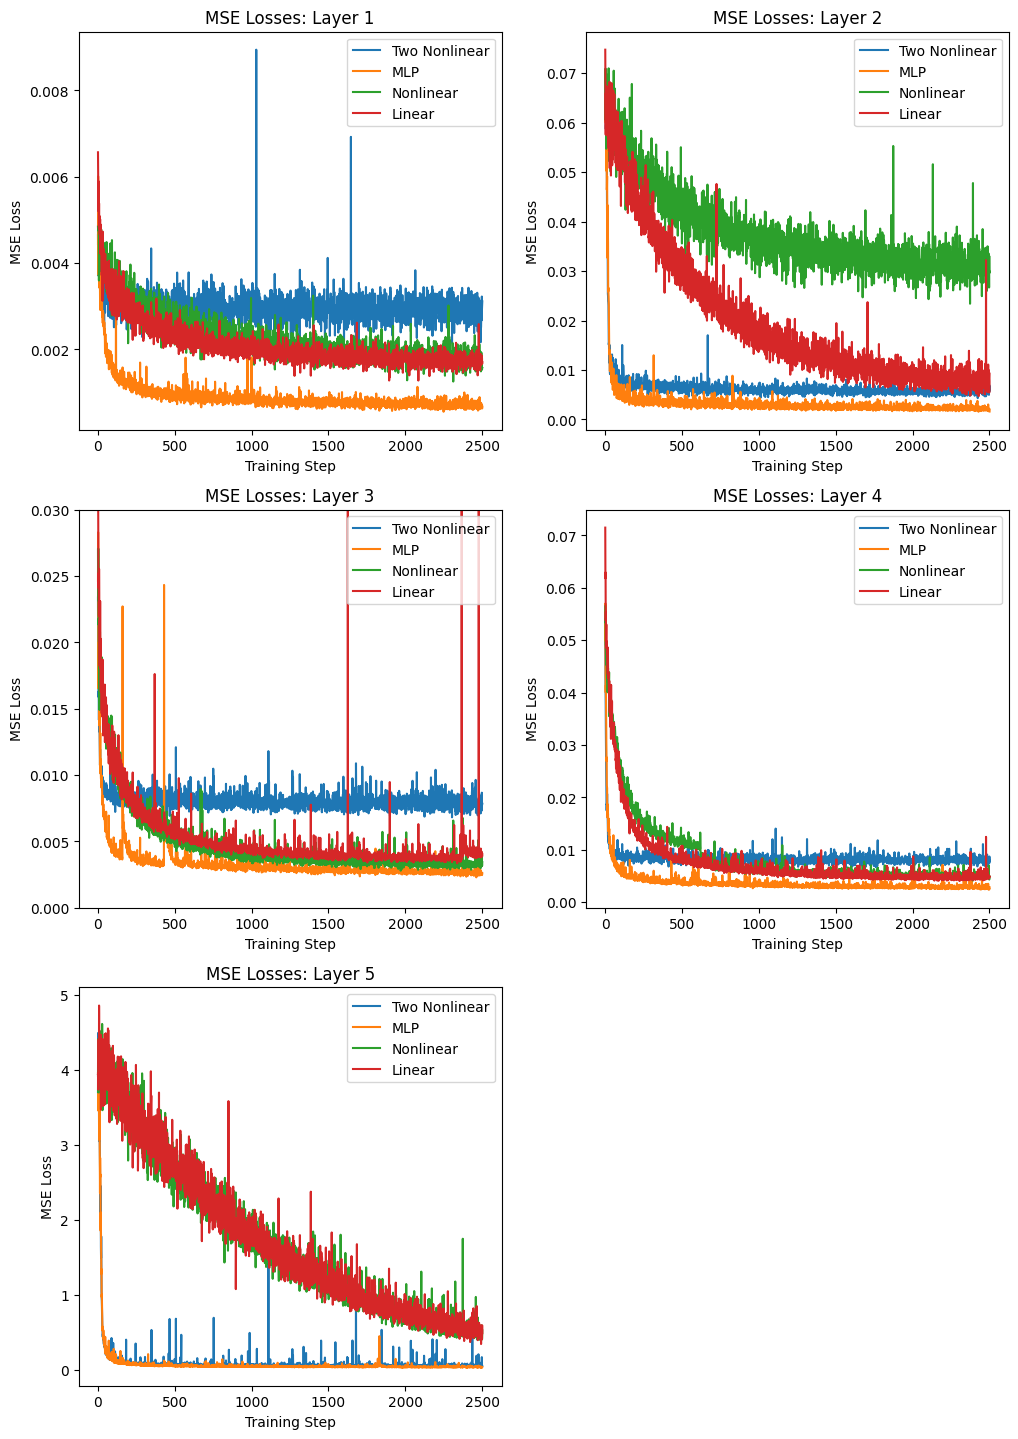

In [18]:
# Plot both losses
import matplotlib.pyplot as plt

num_layers = len(mlp_losses)
num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(len(two_nonlinear_losses)):
    # make a new plot
    # plt.figure()
    plt.subplot(num_rows, num_columns, layer + 1)
    plt.title(f"MSE Losses: Layer {layer+1}")
    plt.plot(two_nonlinear_losses[layer])
    plt.plot(mlp_losses[layer])
    # plt.plot(mlp_losses_no_bias[layer])
    plt.plot(nonlinear_losses[layer])
    # plt.plot(nonlinear_losses_no_bias[layer])
    plt.plot(linear_losses[layer])
    # plt.plot(linear_losses_no_bias[layer])
    if(layer ==2):
        # set max y to 0.05
        plt.ylim(0, 0.03)
    # plt.legend(["Two Nonlinear", "MLP", "MLP_no_bias", "Nonlinear", "Nonlinear_no_bias", "Linear", "Linear_no_bias"])
    plt.legend(["Two Nonlinear", "MLP", "Nonlinear", "Linear"])
    # plt.legend(["MLP_no_bias", "Linear_no_bias"])
    plt.xlabel("Training Step")
    plt.ylabel("MSE Loss")
plt.show()

## Pareto frontier of l1 alpha for linear layer (no bias), then MLP (no bias)

In [7]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
linear_weights_no_bias = []

mlp_optimizers_no_bias = []
linear_optimizers_no_bias = []
l1_alpha = 10
for auto_ind in range(len(autoencoders)//2): # This is per layer
    mlp_weights_no_bias.append([])
    linear_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    linear_optimizers_no_bias.append([])
    for l1_alpha_ind in range(l1_alpha):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features))
        # mlp_weights_no_bias[-1][-1].to(device)
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))

        linear_weights_no_bias[-1].append(linear_no_bias(num_features))
        # linear_weights_no_bias[-1][-1].to(device)
        linear_optimizers_no_bias[-1].append(Adam(linear_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [8]:

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers, l1_alphas):
    mse = nn.MSELoss()
    batch_size = 32
    losses = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_mse = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_l1 = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
                sparse_weight = sparse_weights[cache_name_ind][l1_alpha_ind].to(device)
                x_hat = sparse_weight(input_internal_activations)

                # loss = mse(x_hat, output_internal_activations)
                current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0].to(device)
                indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind)
                indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)
                
                mse_loss = mse(indexed_x_hat, indexed_output_internal_activations)
                l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
                unweighted_loss = mse_loss + l1_loss
                loss = mse_loss + l1_alpha * l1_loss

                loss.backward()
                optimizers[cache_name_ind][l1_alpha_ind].step()
                optimizers[cache_name_ind][l1_alpha_ind].zero_grad()
                losses[cache_name_ind][l1_alpha_ind].append(unweighted_loss.item())
                losses_mse[cache_name_ind][l1_alpha_ind].append(mse_loss.item())
                losses_l1[cache_name_ind][l1_alpha_ind].append(l1_loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 100 == 0:
                    print(f"Layers: {cache_name_ind} | l1 alpha MSE Loss: {mse_loss.item()} | L1 Loss: {l1_loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, l1_loss, current_alive_features_ind, mse_loss, unweighted_loss
                torch.cuda.empty_cache()

            
        if i > 2500:
            # Stop training after 1000 batches
            break
    return losses, losses_mse, losses_l1
# l1_alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 50, 100]
l1_alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, .1, 1]

mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, l1_alphas)
linear_losses_no_bias, linear_losses_no_bias_mse, linear_losses_no_bias_l1 = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias, l1_alphas)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.004733354784548283 | L1 Loss: 27.71285057067871
Layers: 0 | l1 alpha MSE Loss: 0.004719187039881945 | L1 Loss: 27.709638595581055
Layers: 0 | l1 alpha MSE Loss: 0.004732029512524605 | L1 Loss: 27.707304000854492
Layers: 0 | l1 alpha MSE Loss: 0.004733816254884005 | L1 Loss: 27.71148681640625
Layers: 0 | l1 alpha MSE Loss: 0.004734257236123085 | L1 Loss: 27.708663940429688
Layers: 0 | l1 alpha MSE Loss: 0.0047302283346652985 | L1 Loss: 27.70979118347168
Layers: 0 | l1 alpha MSE Loss: 0.004723918624222279 | L1 Loss: 27.72267723083496
Layers: 0 | l1 alpha MSE Loss: 0.004736197181046009 | L1 Loss: 27.71916961669922
Layers: 1 | l1 alpha MSE Loss: 0.06439153850078583 | L1 Loss: 27.713092803955078
Layers: 1 | l1 alpha MSE Loss: 0.06442505121231079 | L1 Loss: 27.714508056640625
Layers: 1 | l1 alpha MSE Loss: 0.06451000273227692 | L1 Loss: 27.712875366210938
Layers: 1 | l1 alpha MSE Loss: 0.06446237117052078 | L1 Loss: 27.711326599121094
Layers: 1 | l1 alpha MSE

  0%|          | 1/10963 [00:04<12:53:12,  4.23s/it]

Layers: 4 | l1 alpha MSE Loss: 4.045109272003174 | L1 Loss: 27.718862533569336
Layers: 4 | l1 alpha MSE Loss: 4.037631511688232 | L1 Loss: 27.712093353271484


  1%|          | 100/10963 [07:06<13:34:31,  4.50s/it]

Layers: 0 | l1 alpha MSE Loss: 0.0014814231544733047 | L1 Loss: 29.73201560974121
Layers: 0 | l1 alpha MSE Loss: 0.0014711512485519052 | L1 Loss: 25.611129760742188
Layers: 0 | l1 alpha MSE Loss: 0.0014765466330572963 | L1 Loss: 11.847331047058105
Layers: 0 | l1 alpha MSE Loss: 0.0016996891936287284 | L1 Loss: 4.244791030883789
Layers: 0 | l1 alpha MSE Loss: 0.002673329319804907 | L1 Loss: 0.7933425903320312
Layers: 0 | l1 alpha MSE Loss: 0.003817987395450473 | L1 Loss: 0.4023781716823578
Layers: 0 | l1 alpha MSE Loss: 0.00455043138936162 | L1 Loss: 0.37991756200790405
Layers: 0 | l1 alpha MSE Loss: 0.004600435495376587 | L1 Loss: 0.38169464468955994
Layers: 1 | l1 alpha MSE Loss: 0.004626172129064798 | L1 Loss: 35.83137130737305
Layers: 1 | l1 alpha MSE Loss: 0.004596203565597534 | L1 Loss: 34.049835205078125
Layers: 1 | l1 alpha MSE Loss: 0.00459839403629303 | L1 Loss: 25.794445037841797
Layers: 1 | l1 alpha MSE Loss: 0.0047584595158696175 | L1 Loss: 12.654579162597656
Layers: 1 | l1

  1%|          | 101/10963 [07:11<13:27:49,  4.46s/it]

Layers: 4 | l1 alpha MSE Loss: 0.3288430869579315 | L1 Loss: 0.5468597412109375


  2%|▏         | 200/10963 [14:13<13:07:03,  4.39s/it]

Layers: 0 | l1 alpha MSE Loss: 0.0013017490273341537 | L1 Loss: 31.975872039794922
Layers: 0 | l1 alpha MSE Loss: 0.0012933457037433982 | L1 Loss: 25.4152889251709
Layers: 0 | l1 alpha MSE Loss: 0.0013097759801894426 | L1 Loss: 13.09552001953125
Layers: 0 | l1 alpha MSE Loss: 0.0014795787865296006 | L1 Loss: 4.349245548248291
Layers: 0 | l1 alpha MSE Loss: 0.0023107200395315886 | L1 Loss: 0.7862086296081543
Layers: 0 | l1 alpha MSE Loss: 0.0034448415972292423 | L1 Loss: 0.37855514883995056
Layers: 0 | l1 alpha MSE Loss: 0.003942614886909723 | L1 Loss: 0.35948845744132996
Layers: 0 | l1 alpha MSE Loss: 0.004059121944010258 | L1 Loss: 0.36912256479263306
Layers: 1 | l1 alpha MSE Loss: 0.005467777140438557 | L1 Loss: 38.870269775390625
Layers: 1 | l1 alpha MSE Loss: 0.005442210007458925 | L1 Loss: 36.214237213134766
Layers: 1 | l1 alpha MSE Loss: 0.005321325734257698 | L1 Loss: 26.90798568725586
Layers: 1 | l1 alpha MSE Loss: 0.005044763907790184 | L1 Loss: 11.90423583984375
Layers: 1 | l

  2%|▏         | 201/10963 [14:17<13:04:32,  4.37s/it]

Layers: 4 | l1 alpha MSE Loss: 0.1359824240207672 | L1 Loss: 1.289018154144287
Layers: 4 | l1 alpha MSE Loss: 0.2363884001970291 | L1 Loss: 0.5111936330795288


  3%|▎         | 300/10963 [21:09<12:14:00,  4.13s/it]

Layers: 0 | l1 alpha MSE Loss: 0.001033222652040422 | L1 Loss: 33.62773132324219
Layers: 0 | l1 alpha MSE Loss: 0.0010361666791141033 | L1 Loss: 25.35782241821289
Layers: 0 | l1 alpha MSE Loss: 0.0010477106552571058 | L1 Loss: 13.720748901367188
Layers: 0 | l1 alpha MSE Loss: 0.001224427716806531 | L1 Loss: 4.327743053436279
Layers: 0 | l1 alpha MSE Loss: 0.0020748667884618044 | L1 Loss: 0.8005441427230835
Layers: 0 | l1 alpha MSE Loss: 0.0035618157126009464 | L1 Loss: 0.3750793933868408
Layers: 0 | l1 alpha MSE Loss: 0.004268457647413015 | L1 Loss: 0.3577389717102051
Layers: 0 | l1 alpha MSE Loss: 0.004517522640526295 | L1 Loss: 0.3725905418395996
Layers: 1 | l1 alpha MSE Loss: 0.0034841448068618774 | L1 Loss: 41.082794189453125
Layers: 1 | l1 alpha MSE Loss: 0.003465541871264577 | L1 Loss: 37.71931838989258
Layers: 1 | l1 alpha MSE Loss: 0.00348118063993752 | L1 Loss: 27.383590698242188
Layers: 1 | l1 alpha MSE Loss: 0.0036988554056733847 | L1 Loss: 11.641538619995117
Layers: 1 | l1 

  3%|▎         | 301/10963 [21:13<12:10:42,  4.11s/it]

Layers: 4 | l1 alpha MSE Loss: 0.2344096153974533 | L1 Loss: 0.5003706216812134


  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.006284926552325487 | L1 Loss: 27.715389251708984
Layers: 0 | l1 alpha MSE Loss: 0.006334547419101 | L1 Loss: 27.7131404876709
Layers: 0 | l1 alpha MSE Loss: 0.006310426630079746 | L1 Loss: 27.702985763549805
Layers: 0 | l1 alpha MSE Loss: 0.006304795388132334 | L1 Loss: 27.71136474609375
Layers: 0 | l1 alpha MSE Loss: 0.006299997679889202 | L1 Loss: 27.712661743164062
Layers: 0 | l1 alpha MSE Loss: 0.0063200583681464195 | L1 Loss: 27.721126556396484
Layers: 0 | l1 alpha MSE Loss: 0.006298281718045473 | L1 Loss: 27.704105377197266
Layers: 0 | l1 alpha MSE Loss: 0.0062978207133710384 | L1 Loss: 27.710485458374023
Layers: 1 | l1 alpha MSE Loss: 0.0707874670624733 | L1 Loss: 27.714643478393555
Layers: 1 | l1 alpha MSE Loss: 0.0703941211104393 | L1 Loss: 27.711645126342773
Layers: 1 | l1 alpha MSE Loss: 0.07028399407863617 | L1 Loss: 27.70416831970215
Layers: 1 | l1 alpha MSE Loss: 0.07052814215421677 | L1 Loss: 27.725418090820312
Layers: 1 | l1 alpha MSE Lo

  0%|          | 1/10963 [00:02<6:49:37,  2.24s/it]

Layers: 4 | l1 alpha MSE Loss: 4.031639099121094 | L1 Loss: 27.71376609802246
Layers: 4 | l1 alpha MSE Loss: 4.021484375 | L1 Loss: 27.703405380249023
Layers: 4 | l1 alpha MSE Loss: 4.042320728302002 | L1 Loss: 27.71856689453125


  1%|          | 100/10963 [03:58<7:17:22,  2.42s/it]

Layers: 0 | l1 alpha MSE Loss: 0.003575268667191267 | L1 Loss: 20.290424346923828
Layers: 0 | l1 alpha MSE Loss: 0.003570804139599204 | L1 Loss: 14.717814445495605
Layers: 0 | l1 alpha MSE Loss: 0.003570947330445051 | L1 Loss: 1.0467480421066284
Layers: 0 | l1 alpha MSE Loss: 0.0035575462970882654 | L1 Loss: 0.5577316284179688
Layers: 0 | l1 alpha MSE Loss: 0.0036255863960832357 | L1 Loss: 0.4325332045555115
Layers: 0 | l1 alpha MSE Loss: 0.0038142919074743986 | L1 Loss: 0.39253291487693787
Layers: 0 | l1 alpha MSE Loss: 0.004196557216346264 | L1 Loss: 0.38281816244125366
Layers: 0 | l1 alpha MSE Loss: 0.004456736147403717 | L1 Loss: 0.3817926347255707
Layers: 1 | l1 alpha MSE Loss: 0.05156732723116875 | L1 Loss: 22.741230010986328
Layers: 1 | l1 alpha MSE Loss: 0.051385700702667236 | L1 Loss: 16.59762191772461
Layers: 1 | l1 alpha MSE Loss: 0.05127725005149841 | L1 Loss: 1.754389762878418
Layers: 1 | l1 alpha MSE Loss: 0.05152493715286255 | L1 Loss: 1.061964988708496
Layers: 1 | l1 al

  1%|          | 101/10963 [04:00<7:23:57,  2.45s/it]

Layers: 4 | l1 alpha MSE Loss: 3.813183546066284 | L1 Loss: 1.275310754776001
Layers: 4 | l1 alpha MSE Loss: 3.8214871883392334 | L1 Loss: 0.6347795724868774
Layers: 4 | l1 alpha MSE Loss: 3.8203747272491455 | L1 Loss: 0.45045340061187744
Layers: 4 | l1 alpha MSE Loss: 3.873538017272949 | L1 Loss: 0.40668797492980957


  2%|▏         | 200/10963 [07:58<7:39:19,  2.56s/it]

Layers: 0 | l1 alpha MSE Loss: 0.003101669019088149 | L1 Loss: 19.34798812866211
Layers: 0 | l1 alpha MSE Loss: 0.0031006145291030407 | L1 Loss: 9.478221893310547
Layers: 0 | l1 alpha MSE Loss: 0.0031035118736326694 | L1 Loss: 0.959304690361023
Layers: 0 | l1 alpha MSE Loss: 0.0031058781314641237 | L1 Loss: 0.6336278915405273
Layers: 0 | l1 alpha MSE Loss: 0.003171845804899931 | L1 Loss: 0.44794008135795593
Layers: 0 | l1 alpha MSE Loss: 0.003489818423986435 | L1 Loss: 0.38707906007766724
Layers: 0 | l1 alpha MSE Loss: 0.004148539621382952 | L1 Loss: 0.373094767332077
Layers: 0 | l1 alpha MSE Loss: 0.0044834851287305355 | L1 Loss: 0.3723784387111664
Layers: 1 | l1 alpha MSE Loss: 0.045310135930776596 | L1 Loss: 22.267166137695312
Layers: 1 | l1 alpha MSE Loss: 0.04511908441781998 | L1 Loss: 11.318607330322266
Layers: 1 | l1 alpha MSE Loss: 0.04508145526051521 | L1 Loss: 1.9389561414718628
Layers: 1 | l1 alpha MSE Loss: 0.045267947018146515 | L1 Loss: 1.2577115297317505
Layers: 1 | l1 a

  2%|▏         | 201/10963 [08:01<7:57:47,  2.66s/it]

Layers: 4 | l1 alpha MSE Loss: 3.781660556793213 | L1 Loss: 0.4185919165611267


  3%|▎         | 300/10963 [11:49<6:05:05,  2.05s/it]

Layers: 0 | l1 alpha MSE Loss: 0.0026376775931566954 | L1 Loss: 18.7105712890625
Layers: 0 | l1 alpha MSE Loss: 0.0026330596301704645 | L1 Loss: 5.709385871887207
Layers: 0 | l1 alpha MSE Loss: 0.0026402678340673447 | L1 Loss: 1.0329033136367798
Layers: 0 | l1 alpha MSE Loss: 0.002636370714753866 | L1 Loss: 0.6753582954406738
Layers: 0 | l1 alpha MSE Loss: 0.0027125906199216843 | L1 Loss: 0.4683348834514618
Layers: 0 | l1 alpha MSE Loss: 0.0030567303765565157 | L1 Loss: 0.39863213896751404
Layers: 0 | l1 alpha MSE Loss: 0.003916342742741108 | L1 Loss: 0.38102394342422485
Layers: 0 | l1 alpha MSE Loss: 0.004247643053531647 | L1 Loss: 0.38041114807128906
Layers: 1 | l1 alpha MSE Loss: 0.04328734055161476 | L1 Loss: 21.692642211914062
Layers: 1 | l1 alpha MSE Loss: 0.04317997023463249 | L1 Loss: 7.238093852996826
Layers: 1 | l1 alpha MSE Loss: 0.04316702485084534 | L1 Loss: 2.069502115249634
Layers: 1 | l1 alpha MSE Loss: 0.04325246438384056 | L1 Loss: 1.3627135753631592
Layers: 1 | l1 al

  3%|▎         | 301/10963 [11:52<6:03:55,  2.05s/it]

Layers: 4 | l1 alpha MSE Loss: 3.477081298828125 | L1 Loss: 0.5503741502761841
Layers: 4 | l1 alpha MSE Loss: 3.582871675491333 | L1 Loss: 0.44630417227745056


  3%|▎         | 301/10963 [11:54<7:01:33,  2.37s/it]


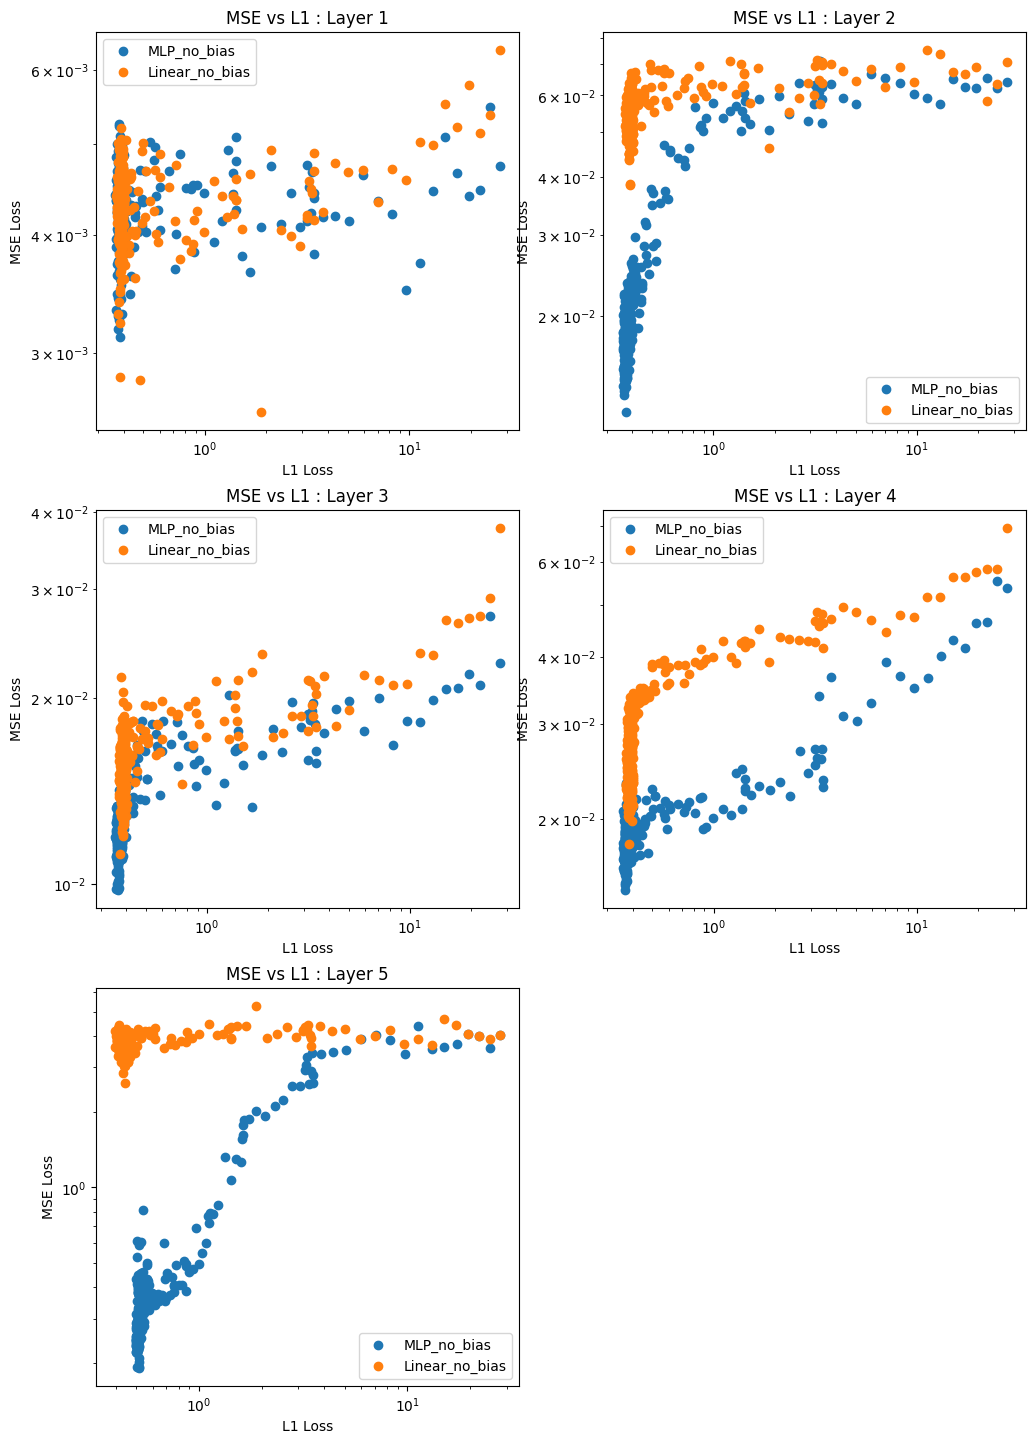

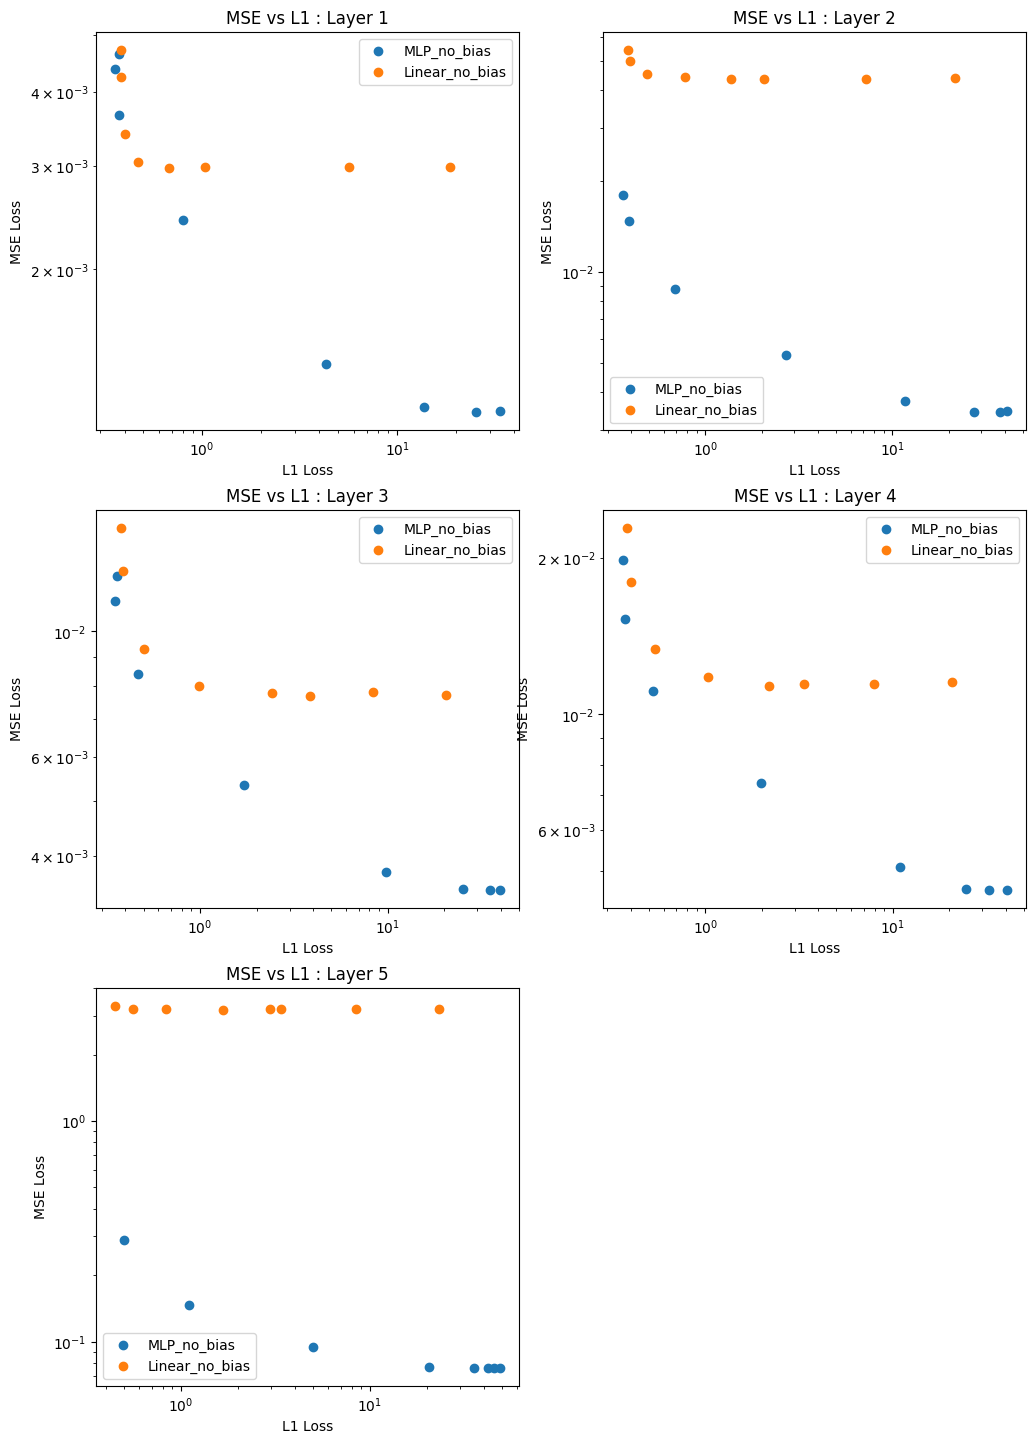

In [36]:
# Plot both losses, just the last value for both MSE and L1
import matplotlib.pyplot as plt

num_layers = len(mlp_losses_no_bias)
num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

l1_alpha_num = len(l1_alphas)
mlp_mse_losses_last = np.zeros((num_layers, l1_alpha_num))
mlp_l1_losses_last = np.zeros((num_layers, l1_alpha_num))
linear_mse_losses_last = np.zeros((num_layers, l1_alpha_num))
linear_l1_losses_last = np.zeros((num_layers, l1_alpha_num))
for layer in range(num_layers):
    for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
        mlp_mse_losses_last[layer, l1_alpha_ind] = mlp_losses_no_bias_mse[layer][l1_alpha_ind][-1]
        mlp_l1_losses_last[layer, l1_alpha_ind] = mlp_losses_no_bias_l1[layer][l1_alpha_ind][-1]
        linear_mse_losses_last[layer, l1_alpha_ind] = linear_losses_no_bias_mse[layer][l1_alpha_ind][-1]
        linear_l1_losses_last[layer, l1_alpha_ind] = linear_losses_no_bias_l1[layer][l1_alpha_ind][-1]


plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    # Subplot for MSE Loss
    plt.subplot(num_rows, num_columns, layer+1)
    plt.title(f"MSE vs L1 : Layer {layer+1}")
    # Grabe the last value of MSE and L1
    mlp_l1_loss = mlp_l1_losses_last[layer]
    mlp_mse_loss = mlp_mse_losses_last[layer]
    linear_l1_loss = linear_l1_losses_last[layer]
    linear_mse_loss = linear_mse_losses_last[layer]
    # Plot
    plt.plot(mlp_l1_loss, mlp_mse_loss, 'o', label="MLP_no_bias")
    plt.plot(linear_l1_loss, linear_mse_loss, 'o', label="Linear_no_bias")
    plt.xlabel("L1 Loss")
    plt.ylabel("MSE Loss")
    # put both on logplot
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
plt.show()

## Sweep over MLP

In [16]:
    
class mlp_no_bias(nn.Module):
    def __init__(self, input_size, hidden_layer_size=None):
        super().__init__()
        if hidden_layer_size is None:
            hidden_layer_size = input_size
        self.linear = nn.Linear(input_size, hidden_layer_size, bias=False)
        self.linear2 = nn.Linear(hidden_layer_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

mlp_weights_no_bias = []

mlp_optimizers_no_bias = []
hidden_layer_sizes = 13
for auto_ind in range(len(autoencoders)//2): # This is per layer
    mlp_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    for hidd_layer_s in range(hidden_layer_sizes):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, 2**(hidd_layer_s+1)))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [17]:
def train_sparse_model_hidden_unit(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers):
    mse = nn.MSELoss()
    batch_size = 32
    hidden_unit_models = len(sparse_weights[0])
    losses = [[[] for _ in range(hidden_unit_models)] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for hidden_unit_m in range(hidden_unit_models):
                sparse_weight = sparse_weights[cache_name_ind][hidden_unit_m].to(device)
                x_hat = sparse_weight(input_internal_activations)

                # loss = mse(x_hat, output_internal_activations)
                current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0].to(device)
                indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind)
                indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)
                
                mse_loss = mse(indexed_x_hat, indexed_output_internal_activations)
                loss = mse_loss

                loss.backward()
                optimizers[cache_name_ind][hidden_unit_m].step()
                optimizers[cache_name_ind][hidden_unit_m].zero_grad()
                losses[cache_name_ind][hidden_unit_m].append(loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 300 == 0:
                    print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, current_alive_features_ind, mse_loss
                torch.cuda.empty_cache()

        if i > 300:
            # Stop training after 1000 batches
            break
    return losses
mlp_losses_no_bias = train_sparse_model_hidden_unit(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | MSE Loss: 0.005501554347574711
Layers: 0 | MSE Loss: 0.00553678534924984
Layers: 0 | MSE Loss: 0.005442761350423098
Layers: 0 | MSE Loss: 0.005443949718028307
Layers: 0 | MSE Loss: 0.0054717641323804855
Layers: 0 | MSE Loss: 0.00543338805437088
Layers: 0 | MSE Loss: 0.005409144330769777
Layers: 0 | MSE Loss: 0.005405251402407885
Layers: 0 | MSE Loss: 0.005431877449154854
Layers: 0 | MSE Loss: 0.005403609946370125
Layers: 0 | MSE Loss: 0.0054214466363191605
Layers: 0 | MSE Loss: 0.005428903270512819
Layers: 0 | MSE Loss: 0.005418367218226194
Layers: 1 | MSE Loss: 0.06880893558263779
Layers: 1 | MSE Loss: 0.06885495781898499
Layers: 1 | MSE Loss: 0.06853997707366943
Layers: 1 | MSE Loss: 0.06845316290855408
Layers: 1 | MSE Loss: 0.06851335614919662
Layers: 1 | MSE Loss: 0.0686269998550415
Layers: 1 | MSE Loss: 0.06857927143573761
Layers: 1 | MSE Loss: 0.0686480700969696
Layers: 1 | MSE Loss: 0.06843666732311249
Layers: 1 | MSE Loss: 0.06871131807565689
Layers: 1 | MSE Loss: 0

  0%|          | 1/10963 [00:02<8:23:12,  2.75s/it]

Layers: 4 | MSE Loss: 4.555083751678467


  3%|▎         | 300/10963 [13:46<8:11:05,  2.76s/it] 

Layers: 0 | MSE Loss: 0.004248362500220537
Layers: 0 | MSE Loss: 0.004250658210366964
Layers: 0 | MSE Loss: 0.0042420318350195885
Layers: 0 | MSE Loss: 0.00382217182777822
Layers: 0 | MSE Loss: 0.0032627990003675222
Layers: 0 | MSE Loss: 0.002748209750279784
Layers: 0 | MSE Loss: 0.002356917131692171
Layers: 0 | MSE Loss: 0.0019626086577773094
Layers: 0 | MSE Loss: 0.0015897859120741487
Layers: 0 | MSE Loss: 0.00132092391140759
Layers: 0 | MSE Loss: 0.001136928447522223
Layers: 0 | MSE Loss: 0.0010089885909110308
Layers: 0 | MSE Loss: 0.001014913315884769
Layers: 1 | MSE Loss: 0.05118892341852188
Layers: 1 | MSE Loss: 0.049422748386859894
Layers: 1 | MSE Loss: 0.01966453343629837
Layers: 1 | MSE Loss: 0.01270791795104742
Layers: 1 | MSE Loss: 0.009349728003144264
Layers: 1 | MSE Loss: 0.008106575347483158
Layers: 1 | MSE Loss: 0.006919429171830416
Layers: 1 | MSE Loss: 0.005623080767691135
Layers: 1 | MSE Loss: 0.004562114365398884
Layers: 1 | MSE Loss: 0.003838918637484312
Layers: 1 |

  3%|▎         | 301/10963 [13:49<8:10:50,  2.76s/it]

Layers: 4 | MSE Loss: 0.06059036776423454


  3%|▎         | 301/10963 [13:52<8:11:25,  2.77s/it]


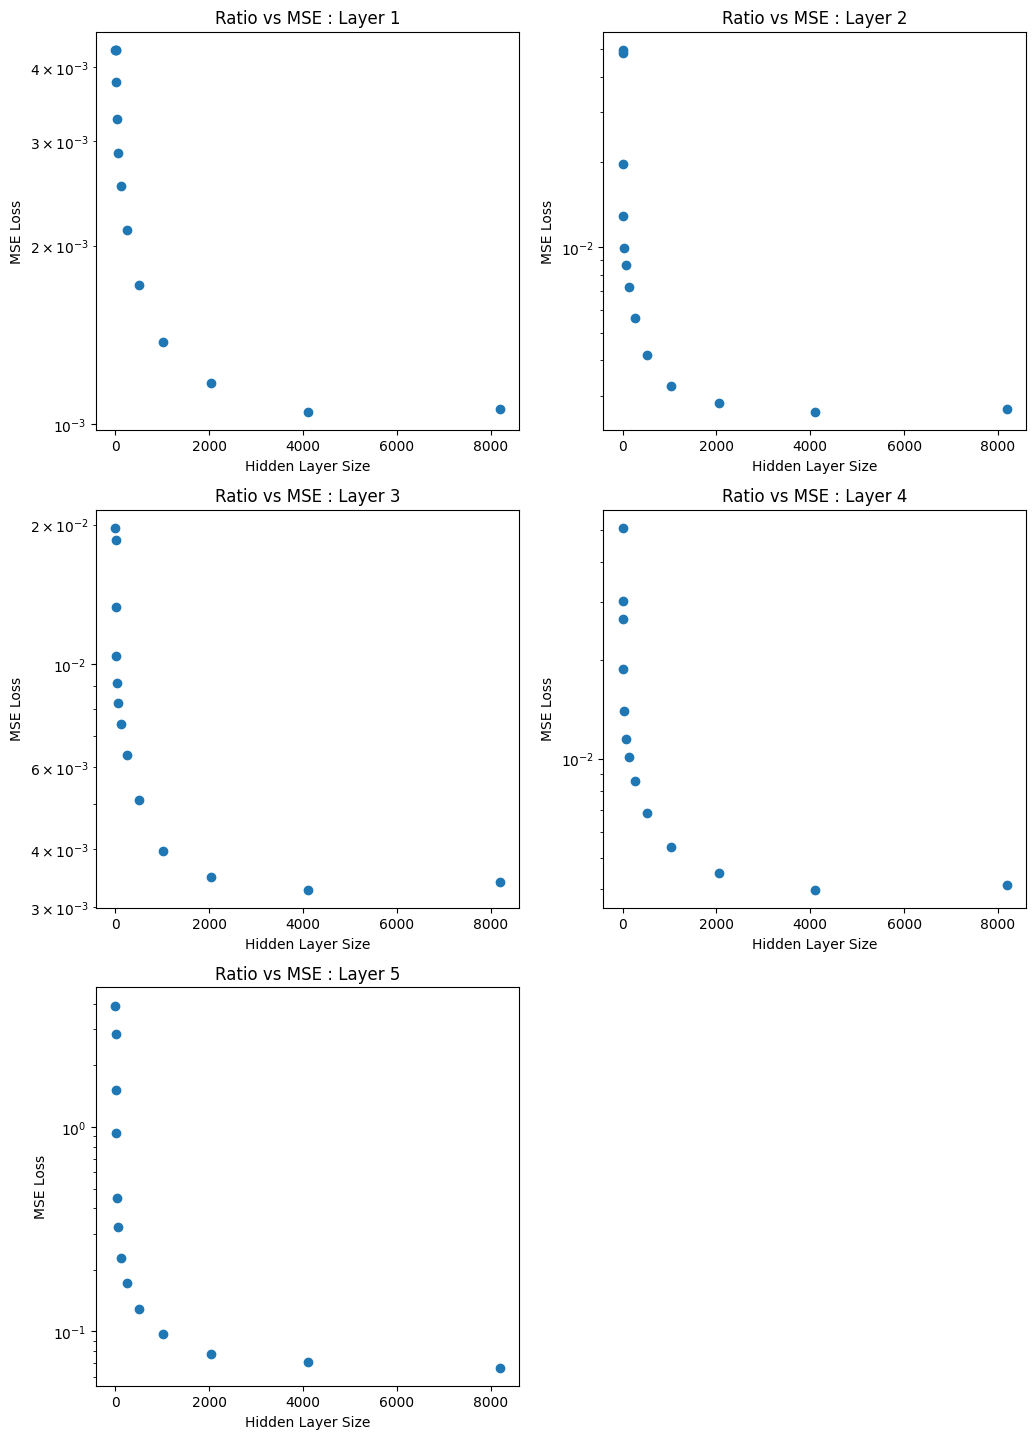

In [20]:
# Plot both losses, just the last value for both MSE and L1
import matplotlib.pyplot as plt

num_layers = len(mlp_losses_no_bias)
num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

hidden_layer_sizes
mlp_losses_last = np.zeros((num_layers, hidden_layer_sizes))
for layer in range(num_layers):
    for hidden_layer_s in range(hidden_layer_sizes):
        mlp_losses_last[layer, hidden_layer_s] = mlp_losses_no_bias[layer][hidden_layer_s][-1]

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed
ratios = [2**(i+1) for i in range(hidden_layer_sizes)]
for layer in range(num_layers):
    # Subplot for MSE Loss
    plt.subplot(num_rows, num_columns, layer+1)
    plt.title(f"Ratio vs MSE : Layer {layer+1}")
    # Grabe the last value of MSE and L1
    mlp_l1_loss = mlp_losses_last[layer]
    # Plot
    plt.plot(ratios, mlp_l1_loss, 'o')
    plt.yscale('log')
    # plt.xscale('log')
    # plt.legend()
    plt.ylabel("MSE Loss")
    plt.xlabel("Hidden Layer Size")
plt.show()

In [13]:
ratios

[2, 4, 8, 16, 32, 64, 128, 256]

In [31]:
len(mlp_losses_no_bias[0][0])

5

In [21]:
# Get the losses for each feature
mse = nn.MSELoss(reduction="none")
l1_alpha = 1e-3
batch_size = 32

# with dataset.formatted_as("pt"):
#     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
max_batches = 1
num_alive_features = alive_features_ind.sum(dim=1).cpu()
loss_diff = [torch.zeros(num_alive_feat) for num_alive_feat in num_alive_features]
# loss_diff = torch.zeros((len(cache_names)//2, 1024))
norms = np.zeros(len(cache_names)//2)
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            if(i == 0):
                # Print the norms of both input & output
                print(f"Layer: {cache_name_ind+1}")
                print(f"Input Norms: {input_internal_activations.norm(dim=1).mean()}")
                print(f"Output Norms: {output_internal_activations.norm(dim=1).mean()}")
                norms[cache_name_ind] = output_internal_activations.norm(dim=1).mean().cpu()
                
            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            if(i == 0):
                # Also check dead features
                print(f"Input Dead Features: {(input_internal_activations.count_nonzero(dim=0) == 0).sum()}")
                print(f"Output Dead Features: {(output_internal_activations.count_nonzero(dim=0) == 0).sum()}")

            x_hat_mlp = mlp_weights[cache_name_ind](input_internal_activations)
            x_hat_linear = linear_weights[cache_name_ind](input_internal_activations)
            
            current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0].to(device)
            index_x_hat_mlp = x_hat_mlp.index_select(dim=1, index=current_alive_features_ind)
            index_x_hat_linear = x_hat_linear.index_select(dim=1, index=current_alive_features_ind)
            index_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)

            # We want to compare the MLP loss & linear loss
            # for every feature, so we mean the batch & pos, but not the feature
            mlp_loss = mse(index_x_hat_mlp, index_output_internal_activations).mean(dim=0).cpu()
            linear_loss = mse(index_x_hat_linear, index_output_internal_activations).mean(dim=0).cpu()

            # instead of mse, do cosine sim
            # mlp_loss = torch.cosine_similarity(x_hat_mlp, output_internal_activations, dim=1).cpu()
            # linear_loss = torch.cosine_similarity(x_hat_linear, output_internal_activations, dim=1).cpu()
            loss_diff[cache_name_ind] += linear_loss - mlp_loss
        if(i >= max_batches):
            break
loss_diff =  [loss_d / max_batches for loss_d in loss_diff]

  0%|          | 1/10963 [00:00<41:33,  4.40it/s]

Layer: 1
Input Norms: 7.102331161499023
Output Norms: 4.217299461364746
Input Dead Features: 2125
Output Dead Features: 2380
Layer: 2
Input Norms: 8.927879333496094
Output Norms: 7.031189441680908
Input Dead Features: 1703
Output Dead Features: 2511
Layer: 3
Input Norms: 13.17062759399414
Output Norms: 9.744373321533203
Input Dead Features: 1222
Output Dead Features: 1979
Layer: 4
Input Norms: 15.069483757019043
Output Norms: 13.083235740661621
Input Dead Features: 1643
Output Dead Features: 1785
Layer: 5
Input Norms: 16.477439880371094
Output Norms: 56.822471618652344
Input Dead Features: 979
Output Dead Features: 2618


In [22]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


layer 0: 0.699
layer 1: 0.872
layer 2: 0.930
layer 3: 0.937
layer 4: 0.996


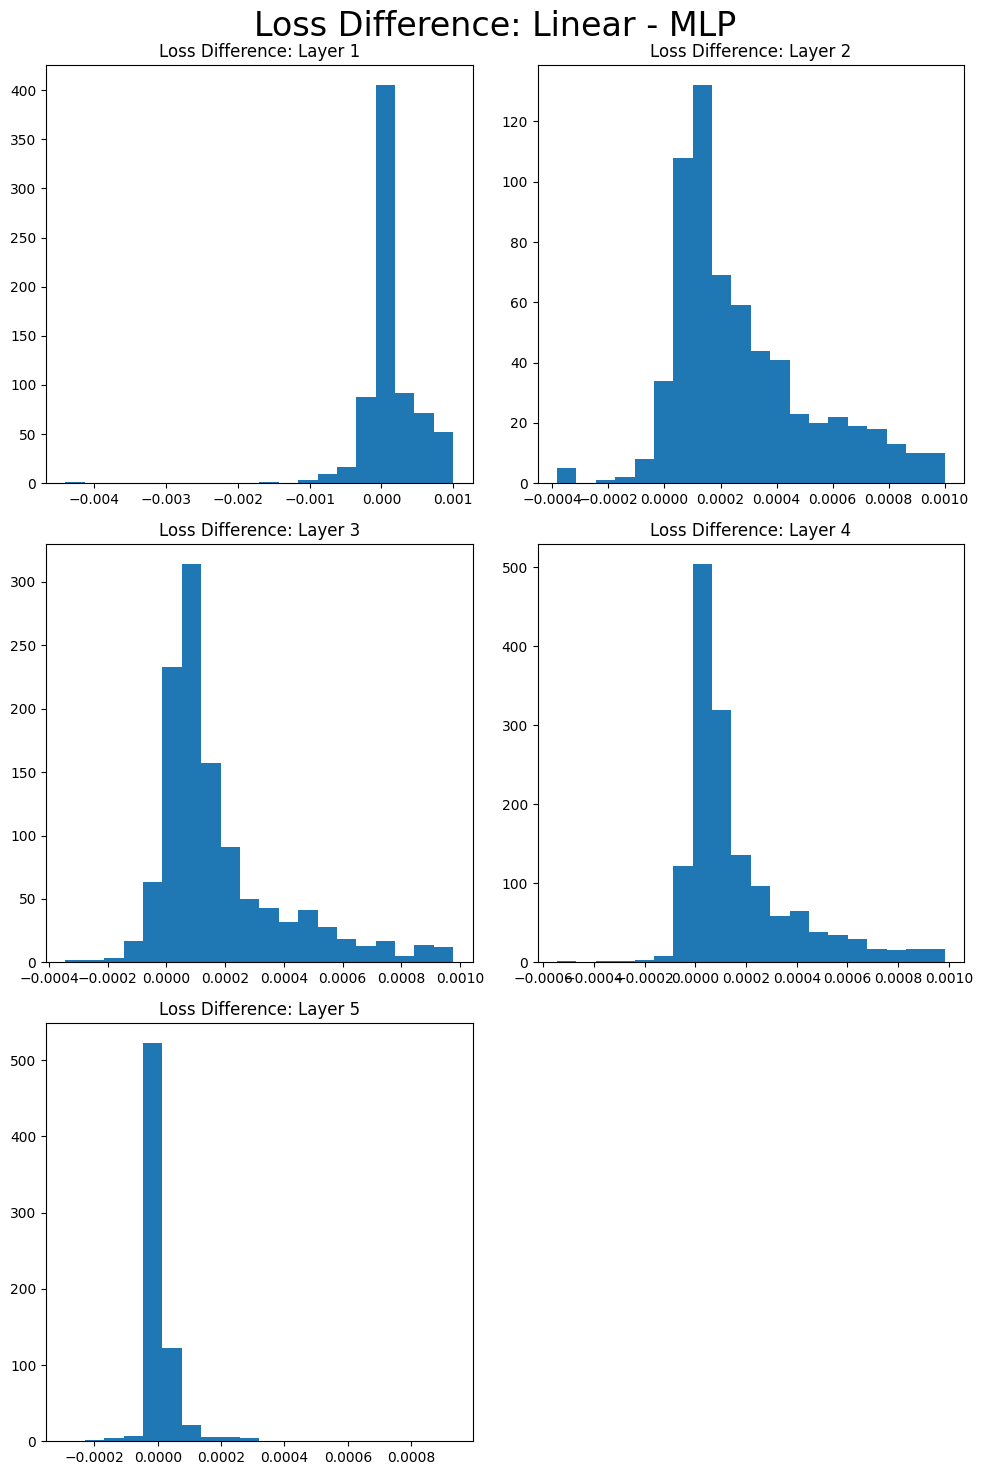

In [28]:
import matplotlib.pyplot as plt
normalization_per_layer = (norms/norms.min())**2

outlier_thresh =  10.0
num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.01
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy() / normalization_per_layer[layer]
    # filtered = loss_d[~is_outlier(loss_d, outlier_thresh)]
    threshold = 0.001
    filtered = loss_d[loss_d < threshold]
    percent_below_threshold = loss_d[loss_d < threshold].shape[0] / loss_d.shape[0]
    print(f"layer {layer}: {percent_below_threshold:.3f}")
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.hist(filtered, bins = 20)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
plt.suptitle("Loss Difference: Linear - MLP", fontsize=24)
plt.tight_layout()
plt.show()

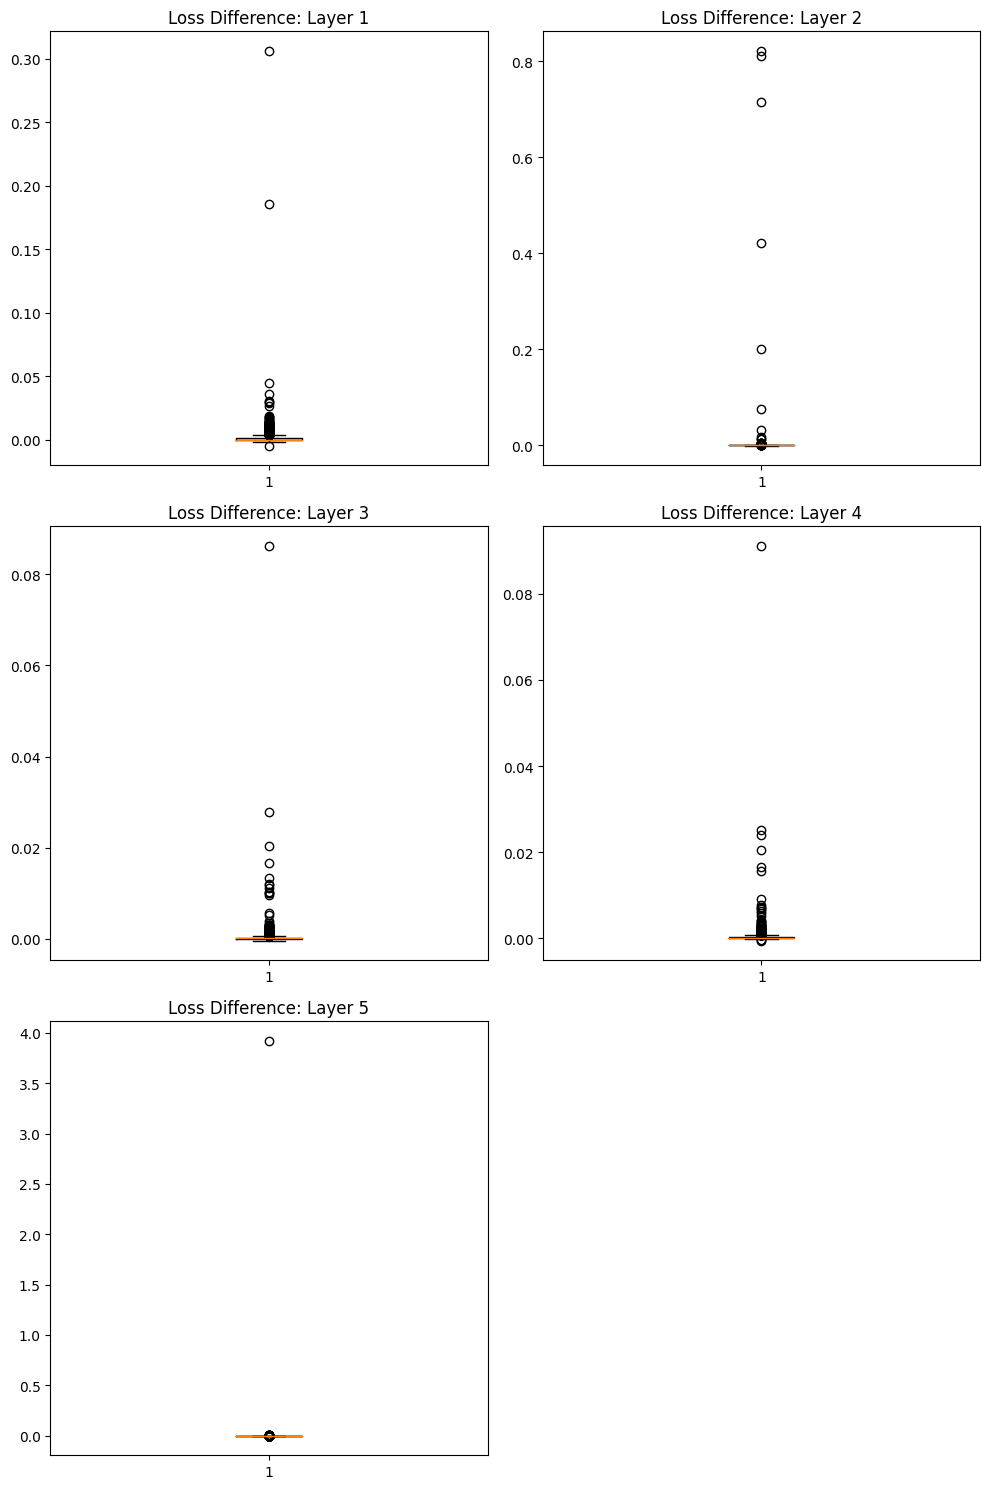

In [25]:
import matplotlib.pyplot as plt

num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.01
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy()/ normalization_per_layer[layer]
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.boxplot(loss_d)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")

plt.tight_layout()
plt.show()

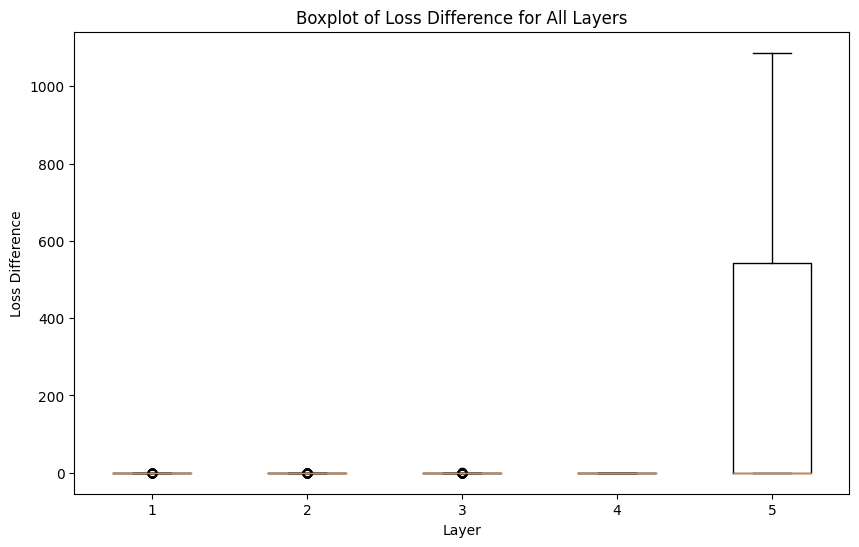

In [19]:
import matplotlib.pyplot as plt

# Collect all loss_diff data for each layer into a list
all_layers_loss_diff = [loss_diff[layer] for layer in range(len(loss_diff))]

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.boxplot(all_layers_loss_diff)
plt.title("Boxplot of Loss Difference for All Layers")
plt.xlabel("Layer")
plt.ylabel("Loss Difference")

plt.show()

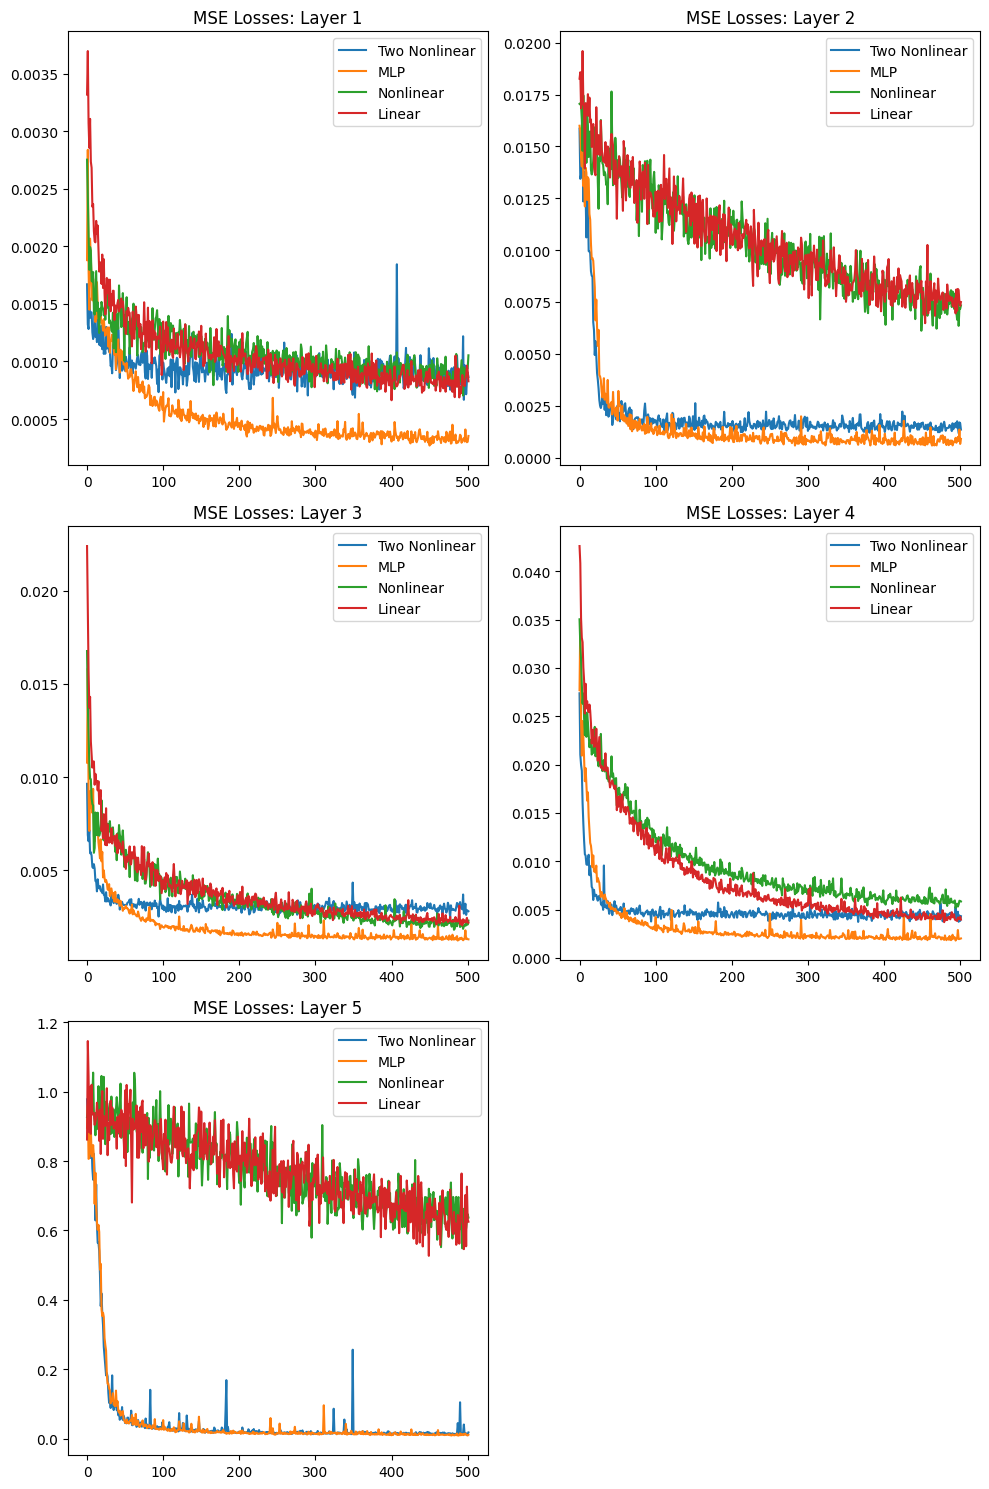

In [15]:
import matplotlib.pyplot as plt

num_layers = len(two_nonlinear_losses)
num_columns = 2  # You can adjust this based on how many plots you want per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"MSE Losses: Layer {layer+1}")
    plt.plot(two_nonlinear_losses[layer], label="Two Nonlinear")
    plt.plot(mlp_losses[layer], label="MLP")
    plt.plot(nonlinear_losses[layer], label="Nonlinear")
    plt.plot(linear_losses[layer], label="Linear")
    plt.legend()

plt.tight_layout()
plt.show()


In [24]:
nonlinear_losses, linear_loss

(array([0.00114306, 0.02376839, 0.00199088, 0.00503561, 0.70069301]),
 array([0.00112041, 0.02399791, 0.00216295, 0.00460967, 0.70566905]))

In [53]:
from baukit import TraceDict
mse = nn.MSELoss()
l1_alpha = 1e-3
datapoints = dataset.num_rows
batch_size = 32
losses = np.zeros(len(sparse_weights))
with dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(dl):
        batch = batch.to(device)
        with torch.no_grad():
            # Get LLM intermediate activations
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        # # Get every 2 cache names (since they're matched up)
        for cache_name_ind in range(len(cache_names)//2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[(cache_name_ind*2)]
            output_cache_name = cache_names[(cache_name_ind*2)+1]
            input_autoencoder = autoencoders[(cache_name_ind*2)]
            output_autoencoder = autoencoders[(cache_name_ind*2)+1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output
            # check if instance tuple ie a layer output
            if(isinstance(input_activations, tuple)):
                input_activations = input_activations[0]
            if(isinstance(output_activations, tuple)):
                output_activations = output_activations[0]
            # Rearrange to (batch_size*seq_length, num_features)
            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n" )
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n" )
            # Encode
            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)
            # Encode
            x_hat = sparse_weights[cache_name_ind](input_internal_activations)
            # Get loss
            loss = mse(x_hat, output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha*l1_loss
            # Backprop
            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind] = loss.item()
            if(i%50==0):
                print(f"Layers: {cache_name_ind} |  MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")


Layers: 0 |  MSE Loss: 0.0032902932725846767 | L1 Loss: 27.721176147460938
Layers: 1 |  MSE Loss: 0.045880552381277084 | L1 Loss: 27.712087631225586
Layers: 2 |  MSE Loss: 0.02548954077064991 | L1 Loss: 27.71087646484375
Layers: 3 |  MSE Loss: 0.0651974007487297 | L1 Loss: 27.717008590698242
Layers: 4 |  MSE Loss: 0.8611162900924683 | L1 Loss: 27.709190368652344
Layers: 0 |  MSE Loss: 0.001719774678349495 | L1 Loss: 24.83885955810547
Layers: 1 |  MSE Loss: 0.038391195237636566 | L1 Loss: 26.483190536499023
Layers: 2 |  MSE Loss: 0.0042221806943416595 | L1 Loss: 28.59328269958496
Layers: 3 |  MSE Loss: 0.02699713036417961 | L1 Loss: 28.991947174072266
Layers: 4 |  MSE Loss: 0.8554728031158447 | L1 Loss: 29.95911979675293
Layers: 0 |  MSE Loss: 0.0017383686499670148 | L1 Loss: 24.861730575561523
Layers: 1 |  MSE Loss: 0.035102322697639465 | L1 Loss: 26.954181671142578
Layers: 2 |  MSE Loss: 0.0031695878133177757 | L1 Loss: 29.906362533569336
Layers: 3 |  MSE Loss: 0.018583638593554497 | 

In [55]:
losses_mlp, losses

# See if the top weights have high cosine similarity between the two

In [13]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
# for f_out, f_in in indices:
    # Find the cosine similarity between these two vectors

dict_in = autoencoders[0].get_learned_dict()
dict_out = autoencoders[1].get_learned_dict()


In [1]:
# f2 = ReLU(w*f1 + b)
'''
d1= [f_0, f_1]

w = [w00, w01]
    [w10, w11]

f2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]
'''

'\nd1= [f_0, f_1]\n\nw = [w00, w01]\n    [w10, w11]\n\nf2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]\n'

In [24]:
squished = Sparse_nonlinear.linear.weight.detach().flatten()
top_val, top_ind = torch.topk(squished, 10)
row_ind = top_ind//num_features
col_ind = top_ind%num_features
# Row is output feature index
# Col is input feature index
top_val, row_ind, col_ind

(tensor([0.3108, 0.3100, 0.3035, 0.3032, 0.3001, 0.2986, 0.2986, 0.2979, 0.2974,
         0.2940], device='cuda:0'),
 tensor([2390, 2863, 2390, 1224, 2863, 1224, 1582, 2863, 1582, 1582],
        device='cuda:0'),
 tensor([3028, 3028,  247,  247,  887,  887,  887, 1904,  247,   67],
        device='cuda:0'))

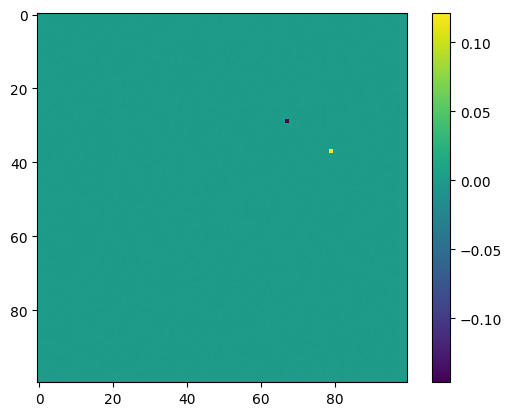

In [25]:
# Plot weight matrix as image
import matplotlib.pyplot as plt
plt.imshow(Sparse_nonlinear.linear.weight[:100,:100].detach().cpu())
plt.colorbar()
plt.show()

In [33]:
threshold_pos = 0.1
threshold_neg = -0.1
total_weights = Sparse_nonlinear.linear.weight.numel()
(Sparse_nonlinear.linear.weight > threshold_pos).count_nonzero() / total_weights, (Sparse_nonlinear.linear.weight < threshold_neg).count_nonzero() / total_weights, total_weights

(tensor(0.0002, device='cuda:0'), tensor(0.0001, device='cuda:0'), 9437184)

In [35]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
indices, Sparse_nonlinear.linear.weight[indices[:,0], indices[:,1]]

(tensor([[   1, 2191],
         [  11,  596],
         [  11, 1184],
         ...,
         [3059, 2127],
         [3059, 3066],
         [3065, 2497]], device='cuda:0'),
 tensor([0.1686, 0.1715, 0.1995,  ..., 0.2472, 0.1418, 0.1529], device='cuda:0',
        grad_fn=<IndexBackward0>))

In [38]:
indices[:10]

tensor([[   1, 2191],
        [  11,  596],
        [  11, 1184],
        [  11, 2676],
        [  14, 2468],
        [  19, 1166],
        [  20,  719],
        [  28,  232],
        [  28,  662],
        [  29, 1404]], device='cuda:0')

In [39]:
indices[10:20]

tensor([[  31, 2115],
        [  31, 2399],
        [  31, 3014],
        [  34, 2422],
        [  37,   79],
        [  37, 1885],
        [  89, 1323],
        [ 103,  837],
        [ 103, 2310],
        [ 105, 1565]], device='cuda:0')

In [40]:
indices[20:30]

tensor([[ 105, 2002],
        [ 105, 2697],
        [ 106,   67],
        [ 106,  146],
        [ 106,  189],
        [ 106,  247],
        [ 106,  330],
        [ 106,  344],
        [ 106,  458],
        [ 106,  690]], device='cuda:0')

In [14]:
f_ind = 1899
Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values, Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values

(tensor([0.0828, 0.0023, 0.0022, 0.0014, 0.0009], device='cuda:0',
        grad_fn=<TopkBackward0>),
 tensor([0.1980, 0.1734, 0.1371, 0.1282, 0.1280], device='cuda:0',
        grad_fn=<TopkBackward0>))

In [18]:
features = [11, 29, 203]
import matplotlib.pyplot as plt
for x in features:
    val = Sparse_nonlinear.linear.weight[x]
#     plt.hist(val.detach().cpu().numpy(), bins=50, label=f"Feature {x}")
    mean = val.mean()
    std = val.std()
    min = val.min()
    max = val.max()
    print(f"Feature {x}: mean: {mean}, std: {std}, min: {min}, max: {max}")
# plt.legend()
plt.show()

Feature 11: mean: 0.0001571535540279001, std: 0.00546741159632802, min: -0.10035543143749237, max: 0.16572602093219757
Feature 29: mean: -0.0004656702221836895, std: 0.011058892123401165, min: -0.2426990568637848, max: 0.15703199803829193
Feature 203: mean: 0.0017885728739202023, std: 0.03143875673413277, min: -0.22366595268249512, max: 0.2349885255098343


In [39]:
f_ind = 9
print("Dead Feature")
print(f"column: {Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values}")
print(f"Row: { Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values}")
    

Dead Feature
column: tensor([0.1078, 0.0246, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)
Row: tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)


In [31]:
# dictionary_activations[:100000].count_nonzero(0).count_nonzero(0)
dictionary_activations[:10000].count_nonzero(0).topk(10, largest=False), dictionary_activations[:10000].count_nonzero(0).topk(10, largest=True)

(torch.return_types.topk(
 values=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 indices=tensor([ 8,  9,  4,  7,  5,  3,  0, 10,  2,  6])),
 torch.return_types.topk(
 values=tensor([4094, 3426, 3297, 2861, 2722, 2140, 1370, 1369, 1354, 1084]),
 indices=tensor([1899,  203,  905,  260, 1773, 1191, 2863, 1224, 2390,  628])))

In [17]:
dictionary_activations.shape

torch.Size([297480, 3072])

In [9]:
from alpha_utils_interp import *
import os
# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 10
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32)

# features = [1,2,3,4,5,6,7,8,9,10]
# features = [5,6]
# features = None
num_features = 30
feature = 0
input_setting = "input_only"
for _ in range(num_features):
    # Check if feature is dead (<10 activations)
    dead_threshold = 10
    # if(dictionary_activations[:, current_feature].count_nonzero() < dead_threshold):
    while(dictionary_activations[:, feature].count_nonzero() < dead_threshold):
        print(f"Feature {feature} is dead")
        feature += 1
    uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], tokenizer, max_seq_length, dataset)
    # get_token_statistics(feature, dictionary_activations[:, feature], dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)
    if(input_setting == "input_only"):
        # Calculate logit diffs on this feature for the full_token_list
        logit_diffs = ablate_feature_direction(model, full_token_list, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="sentences", model_type=model_type)
        # save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type)
        save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type, show=True)
        all_changed_activations = ablate_context_one_token_at_a_time(model, token_list, cache_name, autoencoder, feature, max_ablation_length=30)
        save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    else:
        logit_diffs = ablate_feature_direction(model, dataset, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="dataset")
        _, _, _, full_token_list_ablated, _, full_activations_ablated = get_feature_datapoints(uniform_indices, logit_diffs, tokenizer, max_seq_length, dataset)
        get_token_statistics(feature, logit_diffs, dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, setting="output", num_unique_tokens=10)
        save_token_display(full_token_list_ablated, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = full_activations_ablated)
    # if(ablate_context ==True):
    #     all_changed_activations = ablate_context_one_token_at_a_time(model, dataset, cache_name, autoencoder, feature, max_ablation_length=20)
    #     save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    # combine_images(feature, setting=input_setting, ablate_context=ablate_context)
    feature += 1

100%|██████████| 310/310 [00:10<00:00, 29.77it/s]
/root/sparse_coding/alpha_utils_interp.py:349: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:33.)
  bins = torch.bucketize(best_feature_activations, bin_boundaries)


Feature 0 is dead


NameError: name 'model_type' is not defined

In [ ]:
Sparse_nonlinear.linear.weight[:, x].topk(10)

torch.return_types.topk(
values=tensor([0.0016, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0005], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([1899, 2168, 2598, 1191, 2841, 1595,  601, 2818,  905,  983],
       device='cuda:0'))

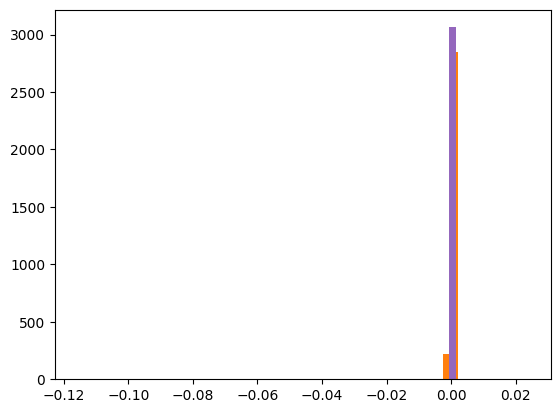

In [50]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[:, x]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

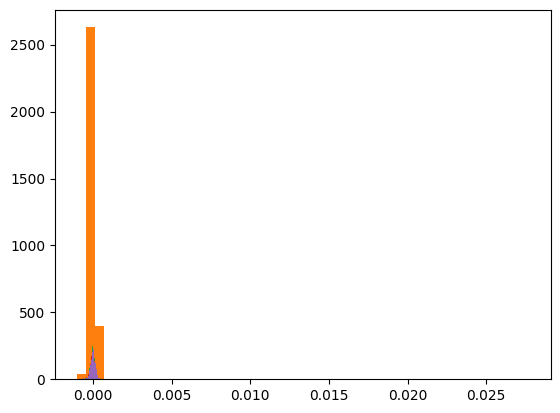

In [51]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[x, :]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

In [37]:
list(Sparse_nonlinear.parameters())

[Parameter containing:
 tensor([[ 0.0124, -0.0044, -0.0002,  ..., -0.0062, -0.0021,  0.0138],
         [ 0.0145, -0.0066, -0.0114,  ...,  0.0170,  0.0121, -0.0112],
         [-0.0014,  0.0121, -0.0046,  ..., -0.0161,  0.0043, -0.0040],
         ...,
         [-0.0075,  0.0023,  0.0118,  ..., -0.0031, -0.0092, -0.0004],
         [-0.0063,  0.0080,  0.0002,  ..., -0.0180, -0.0156,  0.0083],
         [ 0.0041,  0.0157, -0.0164,  ...,  0.0036,  0.0057, -0.0050]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0098, -0.0107,  0.0123,  ...,  0.0170,  0.0130,  0.0111],
        device='cuda:0', requires_grad=True)]

In [ ]:
Sparse_nonlinear.linear.weight.shape

In [ ]:
dictionary_activations[0].count_nonzero(dim=-1).float().mean()